# Power Patterns: Harnessing Electricity for Innovation - Collab Notebook

Welcome to our submission for the Power Patterns: Harnessing Electricity for Innovation Challenge! In this collab notebook, we explore load profile clustering to uncover insights into electricity consumption patterns.

Every building exhibits a unique signature in its electricity consumption behavior, offering energy usage patterns. Load profile clustering enabled us to categorize buildings based on similar energy consumption patterns, paving the way for targeted demand-response programs and enhanced grid management strategies.

In this challenge, our objective is to develop a clustering model capable of grouping buildings into meaningful clusters, tailored to each cluster's characteristics. Throughout this collab notebook, we conduct exploratory data analysis, explore feature engineering techniques, implement unsupervised learning algorithms for clustering, interpret the results and provide recommendations for demand-response programs.

Join us on this journey as we unlock the power patterns of electricity consumption and harness innovation for a sustainable energy future!

# Table of contents

>[Power Patterns: Harnessing Electricity for Innovation - Collab Notebook](#scrollTo=x6Iv2XJzUnxg)

>[Notebook Overview](#scrollTo=zs4Pgld-RwQe)

>[Data Loading](#scrollTo=vOnxrLLThSvA)

>>[Feature Extraction](#scrollTo=r7X5tZgncEO9)

>[Exploratory Data Analysis](#scrollTo=9n8L3rB36TXl)

>[Clustering](#scrollTo=muecB87vzzvi)

>[DBSCAN](#scrollTo=_s9btdZ00PeT)

>[KMeans](#scrollTo=OUmQtR9tzOWe)

>[Visualizing all clusters together](#scrollTo=Y5VrzDl4LY50)

>[Profiling](#scrollTo=FIC3FuUn1T_k)

>[Demand-Response Program](#scrollTo=EZ3rF9APwiT5)

>>[Why do we need Demand-Response Programs:](#scrollTo=gdpK-Cn_IQTm)

>>[Factors Affecting DR Programs](#scrollTo=4eIT8rHNNvjB)

>>[DR Program for each profile](#scrollTo=-WAi2Rwrwl__)

>[Conclusion](#scrollTo=F51026npW3VJ)



# Notebook Overview

1. **Data Loading:**
   - In this initial section, we import the necessary libraries, load and store the dataset containing energy consumption data of buildings, along with the overview of Building Data and Energy Consumption.
   
2. **Feature Engineering and Extraction:**
   - Here, we extract relevant features from the data to capture patterns and variations in energy consumption. We'll explore techniques for feature engineering and delve into time series analysis.
   
3. **Exploratory Data Analysis (EDA):**
   - In this section, we dive into the data to understand its structure, distribution, and key characteristics. We'll visualize the load profiles, analyze trends, and identify any patterns or anomalies.
   
4. **Unsupervised Learning (Clustering Model):**
   - This section focuses on implementing clustering algorithms to group buildings into meaningful clusters based on their energy consumption patterns. We'll experiment with different algorithms, evaluate their performance, and select the best approach for our analysis.
   
5. **Interpretation and Recommendations for DR Programs:**
   - After clustering the buildings, we interpret the results and provide insights into how the clusters can be utilized for specific demand-response programs. We'll offer recommendations for practical implementation based on the characteristics of each cluster.
   
6. **Conclusion:**
   - In the final section, we summarize the key findings from our analysis, reflect on the effectiveness of the clustering approach, and discuss potential next steps for further research or implementation in demand-response programs.


# Data Loading

**Library Imports**

We import various libraries required for data manipulation (pandas, numpy), data visualization (matplotlib, seaborn), statistical analysis (statsmodels, scipy), handling public holidays (holidays), preprocessing and scaling data (sklearn), clustering (KMeans), calculating silhouette scores, performing PCA, handling 3D plots (mpl_toolkits), and managing operating system interfaces (os).

In [1]:
# importing the required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import holidays
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import entropy, gmean, hmean, trim_mean, shapiro, trimboth, kurtosis
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
import scipy
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_samples
from collections import Counter
import pickle

**Mount Google Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Overview of Building Data and Energy Consumption**

**Building Data:** The primary data comprises timestamped electricity load profiles for a total of 1277 buildings. Each building is represented by a Parquet file containing energy consumption data recorded over a specific period. The timestamp granularity is 15 minutes, and the data spans from January 1, 2018, to December 31, 2018.

**Data Format:** The electricity consumption data is stored in Parquet format. Each Parquet file contains a time series of electricity energy consumption for the corresponding building, with energy consumptions recorded at 15-minute intervals.

**Energy Consumption:** Energy consumption values are expressed in kilowatt-hours (kWh) and represent the energy consumed during the 15-minute period ending at each timestamp.

**Building Data Storage: Creating a Dictionary for 1277 Buildings**

**Keys:** Identifiers for each building's data ranging from 'df_1' to 'df_1277'

**Values**: Pandas DataFrame objects containing the data for each respective building

In [3]:
# Here, we will save all buidlings data into a dictionary called 'dfs'

# Provide path of your folder containing the data
path_to_your_parquet_files = ""
dfs = {}
for i in range(1277):   #1277 is the buildings count
  j = i + 1
  # Specify the path to your Parquet file
  parquet_file_path = path_to_your_parquet_files + str(j) + '.parquet'

  # Read the Parquet file
  df = pd.read_parquet(parquet_file_path)
  dfs[f'df_{j}'] = df

## Feature Extraction

We are implementing a set of functions to enrich our dataset with additional features derived from the timestamped electricity load profiles and electricity consumption of 1277 buildings.

We created functions based on the following data considerations:

**Seasons:**

| **Season** | **Months**                  |
|------------|-----------------------------|
| Winter     | December, January, February|
| Spring     | March, April, May          |
| Summer     | June, July, August         |
| Autumn     | September, October, November|

**Time of the Day:**


| **Time of Day** | **Time Range**      |
|-----------------|---------------------|
| Morning         | 5 AM to 11 AM       |
| Afternoon       | 12 PM to 3 PM       |
| Evening         | 4 PM to 7 PM        |
| Night           | 8 PM to 4 AM        |

**Holidays:** U.S federal holidays imported from the `holidays` library.

In [5]:
# Here, we define some functions that we will add in each building data to increase our features
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Unknown'

def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour <= 15:
        return 'Afternoon'
    elif 15 < hour <= 19:
        return 'Evening'
    else:
        return 'Night'

def get_day_type(day_of_week):
    if day_of_week < 5:  # Monday to Friday (0 to 4)
        return 'Weekday'
    else:  # Saturday and Sunday (5 and 6)
        return 'Weekend'

us_holidays = holidays.US()
us_holidays

def lagged_features(df, lag_period):
  df[f'lagby_{lag_period}'] = df['out.electricity.total.energy_consumption'].shift(lag_period)
  df['lag_diff'] = df['out.electricity.total.energy_consumption'] - df[f'lagby_{lag_period}']
  df['lag_%'] = (df['out.electricity.total.energy_consumption'] - df[f'lagby_{lag_period}'])*100 / df[f'lagby_{lag_period}']
  df['hourly_lag'] = df['out.electricity.total.energy_consumption'].shift(4)
  df['hourly_lag_diff'] = df['out.electricity.total.energy_consumption'] - df['hourly_lag']
  df['daily_lag'] = df['out.electricity.total.energy_consumption'].shift(24 * 4)
  df['daily_lag_diff'] = df['out.electricity.total.energy_consumption'] - df['daily_lag']
  df['monthly_lag'] = df['out.electricity.total.energy_consumption'].shift(24 * 30 * 4)
  df['monthly_lag_diff'] = df['out.electricity.total.energy_consumption'] - df['monthly_lag']
  return df

def moving_average(df, window_size):
  df['moving_average'] = df['out.electricity.total.energy_consumption'].rolling(window=window_size, min_periods=1).mean()
  return df
def moving_median(df, window_size):
  df['moving_median'] = df['out.electricity.total.energy_consumption'].rolling(window=window_size, min_periods=1).median()
  return df
def exponential_smoothing(df, alpha):
  df['smoothed_value'] = df['out.electricity.total.energy_consumption'].ewm(alpha=alpha).mean()
  return df


percentiles = [25, 50, 75, 90, 95 ,99, 100]
# # Function to calculate percentiles
def calculate_percentiles(row, percentiles):
    return pd.Series(np.percentile(row, percentiles), index=[f'percentile_{p}' for p in percentiles])
percentile_columns = [f'percentile_{p}' for p in percentiles]


threshold_before_sunset = pd.to_datetime("17:00:00").time()  # Example: 5:00 PM
threshold_after_sunrise = pd.to_datetime("07:00:00").time()  # Example: 7:00 AM



In [6]:
# Here, we will add features in per building data using above functions and some additional time series features too.


def extract_time_elements(df, lagged_window_size, alpha):
  new_row = pd.DataFrame({'timestamp': pd.to_datetime('2018-01-01 00:00:00'), 'out.electricity.total.energy_consumption': 0}, index = [0])
  df = pd.concat([new_row, df]).reset_index(drop=True)
  df['timestamp'] = pd.to_datetime(df['timestamp'])
  df['month'] = df['timestamp'].dt.month
  df['day_of_week'] = df['timestamp'].dt.dayofweek    # 0 - Monday
  df['date'] = df['timestamp'].dt.day
  df['week_of_month'] = (df['date'] + 6) // 7
  df['hour'] = df['timestamp'].dt.hour
  df['Season'] = df['month'].apply(get_season)
  df['TimeOfDay'] = df['hour'].apply(get_time_of_day)
  df['weekday/end'] = df['day_of_week'].apply(get_day_type)
  df['IsHoliday'] = df['timestamp'].apply(lambda x: 1 if x in us_holidays else 0)
  df = lagged_features(df, lagged_window_size)
  df = moving_average(df, lagged_window_size)
  df = moving_median(df, lagged_window_size)
  df = exponential_smoothing(df, alpha)
  max_values = df.groupby(['month', 'date'], as_index = False)['out.electricity.total.energy_consumption'].max()
  df = pd.merge(df, max_values, on=['month', 'date'], suffixes=('', '_max_day'))
  df = df.sort_values(by='timestamp')
  skew_values = df.groupby(['month', 'week_of_month'], as_index = False)['out.electricity.total.energy_consumption'].skew()
  df = pd.merge(df, skew_values, on=['month', 'week_of_month'], suffixes=('', '_skew_day'))
  kurto_values = df.groupby(['month', 'week_of_month'], as_index = False)['out.electricity.total.energy_consumption'].apply(pd.Series.kurtosis)
  df = pd.merge(df, kurto_values, on=['month', 'week_of_month'], suffixes=('', '_kurto_day'))
  return df

**Preview of Building - 1(with df_1 as ID) Data Structure**

In [7]:
# Below is the reference that how our per building data will look like.
df_1 = dfs['df_1']
df_1 = extract_time_elements(df_1, 1, 0.2)
df_1.head()

,timestamp,out.electricity.total.energy_consumption,month,day_of_week,date,week_of_month,hour,Season,TimeOfDay,weekday/end,...,daily_lag,daily_lag_diff,monthly_lag,monthly_lag_diff,moving_average,moving_median,smoothed_value,out.electricity.total.energy_consumption_max_day,out.electricity.total.energy_consumption_skew_day,out.electricity.total.energy_consumption_kurto_day
0,2018-01-01 00:00:00,0.000,1,0,1,1,0,Winter,Night,Weekday,...,NaN,NaN,NaN,NaN,0.000,0.000,0.000000,2.988,0.385077,0.443182
1,2018-01-01 00:15:00,2.377,1,0,1,1,0,Winter,Night,Weekday,...,NaN,NaN,NaN,NaN,2.377,2.377,1.320556,2.988,0.385077,0.443182
2,2018-01-01 00:30:00,2.248,1,0,1,1,0,Winter,Night,Weekday,...,NaN,NaN,NaN,NaN,2.248,2.248,1.700656,2.988,0.385077,0.443182
3,2018-01-01 00:45:00,2.138,1,0,1,1,0,Winter,Night,Weekday,...,NaN,NaN,NaN,NaN,2.138,2.138,1.848808,2.988,0.385077,0.443182
4,2018-01-01 01:00:00,1.985,1,0,1,1,1,Winter,Night,Weekday,...,NaN,NaN,NaN,NaN,1.985,1.985,1.889322,2.988,0.385077,0.443182



To generate clusters, we require a unified dataset. Therefore, we'll employ a feature extraction technique known as characteristic-based clustering. This method involves extracting features for each building that effectively summarize the entire time series data.

For each building, we'll derive 190 features (excluding the building ID), resulting in a DataFrame of dimensions (1277, 191). These features are categorized into two main groups:

- 1) Distribution features: These features elucidate the time series attributes of buildings and will serve as the basis for clustering analysis.
- 2) Descriptive features: These features convey informative characteristics and will be utilized post-clustering for profiling purposes.



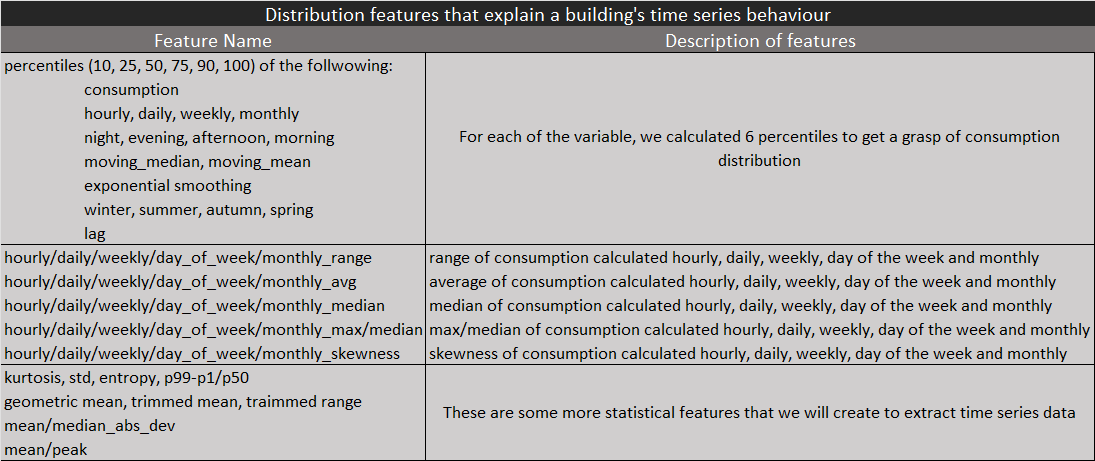

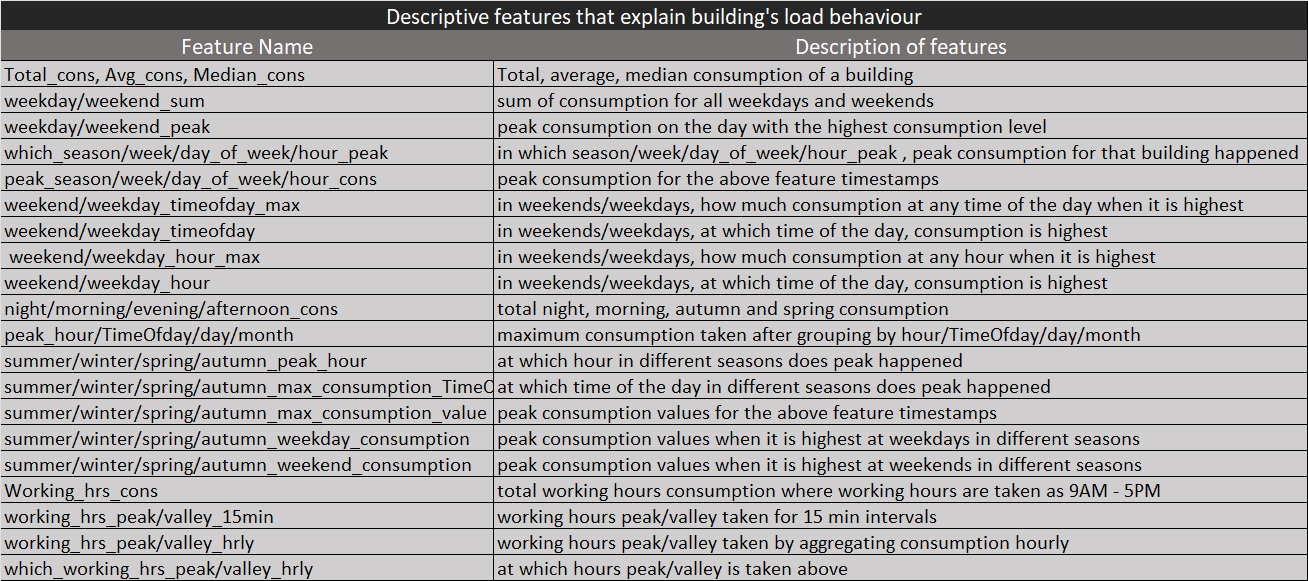

A final DataFrame final_df is created consisting of all the 1277 buildings with the above mentioned features:

In [8]:
final_df = pd.DataFrame()
for i in range(1277):
    j = i + 1
    df = dfs['df_'+ str(j)]
    df_1 = extract_time_elements(df, 1, 0.2)
    df_holi_timeofday = df_1.groupby(['IsHoliday','TimeOfDay'], as_index = False)['out.electricity.total.energy_consumption'].median()
    df_holi_month = df_1.groupby(['IsHoliday','month'], as_index = False)['out.electricity.total.energy_consumption'].median()
    df_holi_hour = df_1.groupby(['IsHoliday','hour'], as_index = False)['out.electricity.total.energy_consumption'].median()
    df_weekend_timeofdsay = df_1.groupby(['weekday/end', 'TimeOfDay'], as_index = False)['out.electricity.total.energy_consumption'].median()
    df_weekend_month = df_1.groupby(['weekday/end', 'month'], as_index = False)['out.electricity.total.energy_consumption'].median()
    df_weekend_hour = df_1.groupby(['weekday/end', 'hour'], as_index = False)['out.electricity.total.energy_consumption'].median()
    percentiles = [25, 50, 75, 95, 100]
    moving_avg_percen = np.percentile(df_1['moving_average'], percentiles)
    moving_median_percen = np.percentile(df_1['moving_median'], percentiles)
    exposmooth_percen = np.percentile(df_1['smoothed_value'], percentiles)
    lagdiff_percen = np.percentile(df_1['lag_%'][2:], percentiles)
    winter_percentiles = np.percentile(df_1[df_1['Season'] == 'Winter']['out.electricity.total.energy_consumption'], percentiles)
    summer_percentiles = np.percentile(df_1[df_1['Season'] == 'Summer']['out.electricity.total.energy_consumption'], percentiles)
    autumn_percentiles = np.percentile(df_1[df_1['Season'] == 'Autumn']['out.electricity.total.energy_consumption'], percentiles)
    spring_percentiles = np.percentile(df_1[df_1['Season'] == 'Spring']['out.electricity.total.energy_consumption'], percentiles)
    night_df = df_1[df_1['TimeOfDay'] == 'Night']
    morning_df = df_1[df_1['TimeOfDay'] == 'Morning']
    evening_df = df_1[df_1['TimeOfDay'] == 'Evening']
    afternoon_df = df_1[df_1['TimeOfDay'] == 'Afternoon']
    summer_df = df_1[df_1['Season'] == 'Summer']
    winter_df = df_1[df_1['Season'] == 'Winter']
    spring_df = df_1[df_1['Season'] == 'Spring']
    autumn_df = df_1[df_1['Season'] == 'Autumn']
    hourly_consumption = df_1.groupby('hour')['out.electricity.total.energy_consumption'].sum()
    timeofday_consumption = df_1.groupby('TimeOfDay')['out.electricity.total.energy_consumption'].sum()
    monthly_consumption = df_1.groupby('month')['out.electricity.total.energy_consumption'].sum()
    summer_hourly_sum = summer_df.groupby(summer_df['timestamp'].dt.hour)['out.electricity.total.energy_consumption'].sum()
    winter_hourly_sum = winter_df.groupby(winter_df['timestamp'].dt.hour)['out.electricity.total.energy_consumption'].sum()
    spring_hourly_sum = spring_df.groupby(spring_df['timestamp'].dt.hour)['out.electricity.total.energy_consumption'].sum()
    autumn_hourly_sum = autumn_df.groupby(autumn_df['timestamp'].dt.hour)['out.electricity.total.energy_consumption'].sum()
    daily_sum = df.groupby(df['timestamp'].dt.date)['out.electricity.total.energy_consumption'].sum()

    working_hrs = df_1[(df_1['hour'] >= 9) & (df_1['hour'] <= 17)]
    working_hrs_hourly = working_hrs.groupby(['month', 'date','hour'], as_index = False)['out.electricity.total.energy_consumption'].sum()
    working_hrs_hourly_max = working_hrs_hourly['out.electricity.total.energy_consumption'].max()
    working_hrs_hourly_min = working_hrs_hourly['out.electricity.total.energy_consumption'].min()

    summer_time_of_day_consumption = summer_df.groupby('TimeOfDay')['out.electricity.total.energy_consumption'].sum()
    winter_time_of_day_consumption = winter_df.groupby('TimeOfDay')['out.electricity.total.energy_consumption'].sum()
    spring_time_of_day_consumption = spring_df.groupby('TimeOfDay')['out.electricity.total.energy_consumption'].sum()
    autumn_time_of_day_consumption = autumn_df.groupby('TimeOfDay')['out.electricity.total.energy_consumption'].sum()
    percentiles_1 = [10, 25, 50, 75, 90, 95, 100]
    consumption_percentiles = np.percentile(df_1['out.electricity.total.energy_consumption'], percentiles_1)
    hourly_percen = np.percentile(df_1.groupby(['month','date','hour'])['out.electricity.total.energy_consumption'].sum(), percentiles_1)
    daily_percen = np.percentile(df_1.groupby(['month','date'])['out.electricity.total.energy_consumption'].sum(), percentiles_1)
    weekly_percen = np.percentile(df_1.groupby(['month','week_of_month'])['out.electricity.total.energy_consumption'].sum(), percentiles_1)
    monthly_percen = np.percentile(df_1.groupby(['month','month'])['out.electricity.total.energy_consumption'].sum(), percentiles_1)
    night_percen = np.percentile(df_1[df_1['TimeOfDay'] == 'Night'].groupby(['month','date','TimeOfDay'])['out.electricity.total.energy_consumption'].sum(), percentiles_1)
    evening_percen = np.percentile(df_1[df_1['TimeOfDay'] == 'Evening'].groupby(['month','date','TimeOfDay'])['out.electricity.total.energy_consumption'].sum(), percentiles_1)
    afternoon_percen = np.percentile(df_1[df_1['TimeOfDay'] == 'Afternoon'].groupby(['month','date','TimeOfDay'])['out.electricity.total.energy_consumption'].sum(), percentiles_1)
    morning_percen = np.percentile(df_1[df_1['TimeOfDay'] == 'Morning'].groupby(['month','date','TimeOfDay'])['out.electricity.total.energy_consumption'].sum(), percentiles_1)


    one_row = pd.DataFrame({ # Informative Features
                        'ID': j,
                        'Total_cons': [df_1['out.electricity.total.energy_consumption'].sum()],  #1
                        'Avg_cons': [df_1['out.electricity.total.energy_consumption'].mean()],    #2
                        'Median_cons': [df_1['out.electricity.total.energy_consumption'].median()],  #3
                        'weekday_sum': [df_1.groupby(['weekday/end'])['out.electricity.total.energy_consumption'].sum()[0]], #4
                        'weekend_sum': [df_1.groupby(['weekday/end'])['out.electricity.total.energy_consumption'].sum()[1]], #5
                        'weekday_peak': [df_1[df_1['weekday/end'] == 'Weekend'].groupby(['month','date','weekday/end'])['out.electricity.total.energy_consumption'].sum().max()], #6    take peak timing
                        'weekend_peak': [df_1[df_1['weekday/end'] == 'Weekday'].groupby(['month','date','weekday/end'])['out.electricity.total.energy_consumption'].sum().max()], #6
                        'which_season_peak': [df_1.groupby(['Season'])['out.electricity.total.energy_consumption'].sum().idxmax()], #15
                        'peak_season_cons': [df_1.groupby(['Season'])['out.electricity.total.energy_consumption'].sum().max()],
                        'which_week_peak': [df_1.groupby(['week_of_month'])['out.electricity.total.energy_consumption'].median().idxmax()], #21
                        'peak_week_cons': [df_1.groupby(['week_of_month'])['out.electricity.total.energy_consumption'].median().max()],
                        'which_day_of_week_peak': [df_1.groupby(['day_of_week'])['out.electricity.total.energy_consumption'].sum().idxmax()],  #22
                        'peak_day_of_week_cons': [df_1.groupby(['day_of_week'])['out.electricity.total.energy_consumption'].sum().max()],
                        'which_hour_peak': [df_1.groupby(['hour'])['out.electricity.total.energy_consumption'].sum().idxmax()],         #23
                        'peak_hour_cons': [df_1.groupby(['hour'])['out.electricity.total.energy_consumption'].sum().max()],
                        'weekend_timeofday_max': [df_weekend_timeofdsay[df_weekend_timeofdsay['weekday/end'] == 'Weekend']['out.electricity.total.energy_consumption'].max()],  #
                        'weekend_timeofday':df_weekend_timeofdsay.loc[df_weekend_timeofdsay[df_weekend_timeofdsay['weekday/end'] == 'Weekend'][['out.electricity.total.energy_consumption']].idxmax()]['TimeOfDay'].values[0],
                        'weekday_timeofday_max': [df_weekend_timeofdsay[df_weekend_timeofdsay['weekday/end'] == 'Weekday']['out.electricity.total.energy_consumption'].max()],
                        'weekday_timeofday':df_weekend_timeofdsay.loc[df_weekend_timeofdsay[df_weekend_timeofdsay['weekday/end'] == 'Weekday'][['out.electricity.total.energy_consumption']].idxmax()]['TimeOfDay'].values[0],
                        'weekend_hour_max': [df_weekend_hour[df_weekend_hour['weekday/end'] == 'Weekend']['out.electricity.total.energy_consumption'].max()],
                        'weekend_hour':df_weekend_hour.loc[df_weekend_hour[df_weekend_hour['weekday/end'] == 'Weekend'][['out.electricity.total.energy_consumption']].idxmax()]['hour'].values[0],
                        'weekday_hour_max': [df_weekend_hour[df_weekend_hour['weekday/end'] == 'Weekday']['out.electricity.total.energy_consumption'].max()],
                        'weekday_hour':df_weekend_hour.loc[df_weekend_hour[df_weekend_hour['weekday/end'] == 'Weekday'][['out.electricity.total.energy_consumption']].idxmax()]['hour'].values[0],
                        'night_cons': night_df['out.electricity.total.energy_consumption'].sum(),
                        'morning_cons': morning_df['out.electricity.total.energy_consumption'].sum(),
                        'evening_cons': evening_df['out.electricity.total.energy_consumption'].sum(),
                        'afternoon_cons': afternoon_df['out.electricity.total.energy_consumption'].sum(),
                        'peak_hour': hourly_consumption.idxmax(),
                        'peak_TimeOfDay': timeofday_consumption.idxmax(),
                        'peak_day': daily_sum.idxmax(),
                        'peak_month': monthly_consumption.idxmax(),
                        'summer_peak_hour': summer_hourly_sum.idxmax(),
                        'winter_peak_hour': winter_hourly_sum.idxmax(),
                        'spring_peak_hour': spring_hourly_sum.idxmax(),
                        'autumn_peak_hour': autumn_hourly_sum.idxmax(),
                        'summer_max_consumption_TimeOfDay': summer_time_of_day_consumption.idxmax(),
                        'summer_max_consumption_value': summer_time_of_day_consumption.max(),
                        'winter_max_consumption_TimeOfDay': winter_time_of_day_consumption.idxmax(),
                        'winter_max_consumption_value': winter_time_of_day_consumption.max(),
                        'spring_max_consumption_TimeOfDay': spring_time_of_day_consumption.idxmax(),
                        'spring_max_consumption_value': spring_time_of_day_consumption.max(),
                        'autumn_max_consumption_TimeOfDay': autumn_time_of_day_consumption.idxmax(),
                        'autumn_max_consumption_value': autumn_time_of_day_consumption.max(),
                        'summer_weekday_consumption': summer_df[summer_df['timestamp'].dt.dayofweek < 5]['out.electricity.total.energy_consumption'].sum(),
                        'summer_weekend_consumption': summer_df[summer_df['timestamp'].dt.dayofweek >= 5]['out.electricity.total.energy_consumption'].sum(),
                        'winter_weekday_consumption': winter_df[winter_df['timestamp'].dt.dayofweek < 5]['out.electricity.total.energy_consumption'].sum(),
                        'winter_weekend_consumption': winter_df[winter_df['timestamp'].dt.dayofweek >= 5]['out.electricity.total.energy_consumption'].sum(),
                        'spring_weekday_consumption': spring_df[spring_df['timestamp'].dt.dayofweek < 5]['out.electricity.total.energy_consumption'].sum(),
                        'spring_weekend_consumption': spring_df[spring_df['timestamp'].dt.dayofweek >= 5]['out.electricity.total.energy_consumption'].sum(),
                        'autumn_weekday_consumption': autumn_df[autumn_df['timestamp'].dt.dayofweek < 5]['out.electricity.total.energy_consumption'].sum(),
                        'autumn_weekend_consumption': autumn_df[autumn_df['timestamp'].dt.dayofweek >= 5]['out.electricity.total.energy_consumption'].sum(),
                        'Working_hrs_cons': working_hrs['out.electricity.total.energy_consumption'].sum(),
                        'working_hrs_peak_15min' : working_hrs['out.electricity.total.energy_consumption'].max(),
                        'working_hrs_valley_15min' : working_hrs['out.electricity.total.energy_consumption'].min(),
                        'working_hrs_peak_hrly' : working_hrs_hourly_max,
                        'working_hrs_valley_hrly' : working_hrs_hourly_min,
                        'which_working_hrs_peak_hrly' : working_hrs_hourly[working_hrs_hourly['out.electricity.total.energy_consumption'] == working_hrs_hourly_max]['hour'].values[0],
                        'which_working_hrs_valley_hrly' : working_hrs_hourly[working_hrs_hourly['out.electricity.total.energy_consumption'] == working_hrs_hourly_min]['hour'].values[0],


                        # Features that explains time series attributes
                        'cons_10': consumption_percentiles[0],'cons_25': consumption_percentiles[1],'cons_50': consumption_percentiles[2],'cons_75': consumption_percentiles[3],'cons_90': consumption_percentiles[4],'cons_95': consumption_percentiles[5],'cons_100': consumption_percentiles[6],
                        'range': (df_1['out.electricity.total.energy_consumption'].max() - df_1['out.electricity.total.energy_consumption'].min()),
                        'hourly_range': ((df_1.groupby(['hour'], as_index = False)[['out.electricity.total.energy_consumption']].sum().apply(lambda x: x.max() - x.min()))[1]),
                        'daily_range': ((df_1.groupby(['date'], as_index = False)[['out.electricity.total.energy_consumption']].sum().apply(lambda x: x.max() - x.min()))[1]),
                        'weekly_range': ((df_1.groupby(['week_of_month'], as_index = False)[['out.electricity.total.energy_consumption']].sum().apply(lambda x: x.max() - x.min()))[1]),
                        'day_of_week_range': ((df_1.groupby(['day_of_week'], as_index = False)[['out.electricity.total.energy_consumption']].sum().apply(lambda x: x.max() - x.min()))[1]),
                        'monthly_range': ((df_1.groupby(['month'], as_index = False)[['out.electricity.total.energy_consumption']].sum().apply(lambda x: x.max() - x.min()))[1]),
                        'monthly_avg' : (df_1.groupby(['month'], as_index = False)[['out.electricity.total.energy_consumption']].sum().median()[1]),
                        'weekly_avg' : (df_1.groupby(['month', 'week_of_month'], as_index = False)[['out.electricity.total.energy_consumption']].sum().median()[1]),
                        'daily_avg' : (df_1.groupby(['month', 'week_of_month', 'day_of_week'], as_index = False)[['out.electricity.total.energy_consumption']].sum().median()[1]),
                        'hourly_avg' : (df_1.groupby(['month', 'week_of_month', 'day_of_week', 'hour'], as_index = False)[['out.electricity.total.energy_consumption']].sum().median()[1]),
                        'hourly_median': (df_1.groupby(df_1['timestamp'].dt.hour)['out.electricity.total.energy_consumption'].median()).median(),
                        'daily_median': (df_1.groupby(df_1['timestamp'].dt.date)['out.electricity.total.energy_consumption'].median()).median(),
                        'weekly_median': (df_1.resample('W', on='timestamp')['out.electricity.total.energy_consumption'].median()).median(),
                        'monthly_median': (df_1.groupby('month')['out.electricity.total.energy_consumption'].median()).median(),
                        'max-percentile_95': df_1['out.electricity.total.energy_consumption'].max() - np.percentile(df_1['out.electricity.total.energy_consumption'], 95),
                        'hourly_max/median': df_1.groupby(df_1['timestamp'].dt.hour)['out.electricity.total.energy_consumption'].apply(lambda x: x.max() / x.median()).median(),
                        'daily_max/median': df_1.groupby(df_1['timestamp'].dt.date)['out.electricity.total.energy_consumption'].apply(lambda x: x.max() / x.median()).median(),
                        'weekly_max/median': df_1.groupby(df_1['timestamp'].dt.isocalendar().week)['out.electricity.total.energy_consumption'].apply(lambda x: x.max() / x.median()).median(),
                        'monthly_max/median': df_1.groupby(df_1['timestamp'].dt.month)['out.electricity.total.energy_consumption'].apply(lambda x: x.max() / x.median()).median(),
                        'hourly_skewness':(df_1.groupby(df_1['timestamp'].dt.hour)['out.electricity.total.energy_consumption'].skew()).median(),
                        'daily_skewness': (df_1.groupby(df_1['timestamp'].dt.date)['out.electricity.total.energy_consumption'].skew()).median(),
                        'weekly_skewness': (df_1.groupby(df_1['timestamp'].dt.isocalendar().week)['out.electricity.total.energy_consumption'].skew()).median(),
                        'monthly_skewness': (df_1.groupby(df_1['timestamp'].dt.month)['out.electricity.total.energy_consumption'].skew()).median(),
                        'kurtosis': kurtosis(df_1['out.electricity.total.energy_consumption'].dropna()),
                        'std': np.std(df_1['out.electricity.total.energy_consumption']),  # 55
                        'entropy':entropy(df_1['out.electricity.total.energy_consumption']),  # 61
                        'p99-p1/p50': (np.percentile(df_1['out.electricity.total.energy_consumption'], 99) - np.percentile(df_1['out.electricity.total.energy_consumption'], 1))/np.percentile(df_1['out.electricity.total.energy_consumption'], 50),
                        'geometric_mean': gmean(df_1[df_1['out.electricity.total.energy_consumption'] != 0]['out.electricity.total.energy_consumption']),
                        'trimmed_mean': trim_mean(df_1['out.electricity.total.energy_consumption'], proportiontocut=0.1),
                        'mean_abs_dev': np.mean(np.abs(df_1['out.electricity.total.energy_consumption'] - np.mean(df_1['out.electricity.total.energy_consumption']))),
                        'median_abs_dev': np.median(np.abs(df_1['out.electricity.total.energy_consumption'] - np.median(df_1['out.electricity.total.energy_consumption']))),
                        'mean/peak': df_1['out.electricity.total.energy_consumption'].mean()/df_1['out.electricity.total.energy_consumption'].max(),
                        'trimmed_range': trimboth(df_1['out.electricity.total.energy_consumption'], 0.1).max() - trimboth(df_1['out.electricity.total.energy_consumption'], 0.1).min(),
                        'hourly_10': hourly_percen[0],'hourly_25': hourly_percen[1],'hourly_50': hourly_percen[2],'hourly_75': hourly_percen[3],'hourly_90': hourly_percen[4], 'hourly_95': hourly_percen[5], 'hourly_100': hourly_percen[6],
                        'daily_10': daily_percen[0],'daily_25': daily_percen[1],'daily_50': daily_percen[2],'daily_75': daily_percen[3],'daily_90': daily_percen[4],'daily_95': daily_percen[5],'daily_100': daily_percen[6],
                        'weekly_10': weekly_percen[0],'weekly_25': weekly_percen[1],'weekly_50': weekly_percen[2],'weekly_75': weekly_percen[3],'weekly_90': weekly_percen[4],'weekly_95': weekly_percen[5],'weekly_100': weekly_percen[6],
                        'monthly_10': monthly_percen[0],'monthly_25': monthly_percen[1],'monthly_50': monthly_percen[2],'monthly_75': monthly_percen[3],'monthly_90': monthly_percen[4],'monthly_95': monthly_percen[5],'monthly_100': monthly_percen[6],
                        'night_10': night_percen[0],'night_25': night_percen[1],'night_50': night_percen[2],'night_75': night_percen[3],'night_90': night_percen[4],'night_95': night_percen[5],'night_100': night_percen[6],
                        'evening_10': evening_percen[0],'evening_25': evening_percen[1],'evening_50': evening_percen[2],'evening_75': evening_percen[3],'evening_90': evening_percen[4],'evening_95': evening_percen[5],'evening_100': evening_percen[6],
                        'afternoon_10': afternoon_percen[0],'afternoon_25': afternoon_percen[1],'afternoon_50': afternoon_percen[2],'afternoon_75': afternoon_percen[3],'afternoon_90': afternoon_percen[4],'afternoon_95': afternoon_percen[5],'afternoon_100': afternoon_percen[6],
                        'morning_10': morning_percen[0],'morning_25': morning_percen[1],'morning_50': morning_percen[2],'morning_75': morning_percen[3],'morning_90': morning_percen[4],'morning_95': morning_percen[5],'morning_100': morning_percen[6],
                        'moving_mean_25': moving_avg_percen[0],'moving_mean_50': moving_avg_percen[1],'moving_mean_75': moving_avg_percen[2],'moving_mean_95': moving_avg_percen[3],'moving_mean_100': moving_avg_percen[4],
                        'moving_median_25': moving_median_percen[0],'moving_median_50': moving_median_percen[1],'moving_median_75': moving_median_percen[2],'moving_median_95': moving_median_percen[3],'moving_median_100': moving_median_percen[4],
                        'expo_25': exposmooth_percen[0],'expo_50': exposmooth_percen[1],'expo_75': exposmooth_percen[2],'expo_95': exposmooth_percen[3],'expo_100': exposmooth_percen[4],
                        'lag_25': lagdiff_percen[0],'lag_50': lagdiff_percen[1],'lag_75': lagdiff_percen[2],'lag_95': lagdiff_percen[3],'lag_100': lagdiff_percen[4],
                        'winter_25': winter_percentiles[0],'winter_50': winter_percentiles[1],'winter_75': winter_percentiles[2],'winter_100': winter_percentiles[4],
                        'summer_25': summer_percentiles[0],'summer_50': summer_percentiles[1],'summer_75': summer_percentiles[2],'summer_100': summer_percentiles[4],
                        'autumn_25': autumn_percentiles[0],'autumn_50': autumn_percentiles[1],'autumn_75': autumn_percentiles[2],'autumn_100': autumn_percentiles[4],
                        'spring_25': spring_percentiles[0],'spring_50': spring_percentiles[1],'spring_75': spring_percentiles[2],'spring_100': spring_percentiles[4]
  })
    final_df = pd.concat([final_df, one_row], axis=0)

final_df

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:197: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)


,ID,Total_cons,Avg_cons,Median_cons,weekday_sum,weekend_sum,weekday_peak,weekend_peak,which_season_peak,peak_season_cons,...,summer_75,summer_100,autumn_25,autumn_50,autumn_75,autumn_100,spring_25,spring_50,spring_75,spring_100
0,1,2.408795e+04,0.687422,0.612000,1.733177e+04,6.756178e+03,257.774000,221.336000,Winter,9.085557e+03,...,0.602000,1.925000,0.384000,0.531000,0.703000,2.239000,0.463000,0.608000,0.754000,2.622000
0,2,2.460349e+03,0.070213,0.062000,1.783170e+03,6.771790e+02,19.423000,13.422000,Summer,7.816870e+02,...,0.107000,0.277000,0.032000,0.045000,0.071000,0.270000,0.037000,0.044000,0.068000,0.290000
0,3,9.449000e+02,0.026966,0.015000,7.161900e+02,2.287100e+02,12.322000,17.196000,Summer,4.281980e+02,...,0.055000,0.468000,0.012000,0.013000,0.018000,0.389000,0.013000,0.015000,0.022000,0.130000
0,4,1.056136e+04,0.301400,0.184000,7.535563e+03,3.025798e+03,40.797000,51.434000,Winter,2.872404e+03,...,0.322000,2.225000,0.117000,0.168000,0.336000,2.092000,0.114000,0.168000,0.353250,2.073000
0,5,1.779647e+04,0.507876,0.433000,1.268043e+04,5.116044e+03,181.737000,189.635000,Winter,6.434691e+03,...,0.470000,3.208000,0.262000,0.370000,0.498250,2.841000,0.312750,0.434000,0.576000,2.837000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1273,1.394102e+06,39.784880,36.488494,1.037882e+06,3.562201e+05,7277.668914,6990.547375,Summer,3.630764e+05,...,61.395439,88.720806,20.789397,35.305677,56.421268,96.744687,20.844043,35.187687,56.723294,87.843725
0,1274,5.970104e+05,17.037481,12.842887,4.968181e+05,1.001922e+05,2247.836140,2891.166915,Summer,1.875802e+05,...,32.694782,54.441134,10.404975,12.626356,22.239976,53.170768,10.494835,11.811969,21.353025,44.203620
0,1275,1.477677e+06,42.169955,38.636934,9.011545e+05,5.765229e+05,10158.871683,7755.368585,Winter,4.011725e+05,...,72.696763,98.224560,13.398386,35.653728,67.504279,95.831424,12.712875,36.169227,68.806628,97.623894
0,1276,6.229248e+05,17.777028,16.620970,4.991760e+05,1.237489e+05,2172.985796,2892.709559,Summer,1.977833e+05,...,30.866470,47.628650,8.775716,14.955000,23.650081,44.860672,8.159914,13.130467,21.100970,39.523013


# Exploratory Data Analysis

**Building 963 with Negative Consumption of Electricity**

In the dataset, we observed that a single building with Building ID 963 has exhibited non-positive electricity consumption.

In [9]:
for i in range(1277):
    j = i + 1
    df = dfs['df_'+ str(j)]
    if len(df[df['out.electricity.total.energy_consumption'] <= 0]) > 0:
      print('Rows with negative consumption of building ID', j ,' is', len(df[df['out.electricity.total.energy_consumption'] <= 0]))

Rows with negative consumption of building ID 963  is 39


There are 39 instances where the electricity consumption for Building ID 963 is non-positive.

**Preview of Building 963 with non-positive Electricity Consumption**

In [10]:
df = dfs['df_963']
df[df['out.electricity.total.energy_consumption'] <= 0].head(5)

,timestamp,out.electricity.total.energy_consumption
bldg_id,,
963,2018-03-19 06:15:00,-0.180833
963,2018-03-19 21:15:00,-0.201497
963,2018-03-19 21:30:00,-0.413133
963,2018-03-19 21:45:00,-0.803168
963,2018-03-19 22:00:00,-0.899525


Even with the presence of non-positive electricity consumption, we are not dropping the building 963 from our dataset because the number of consumption rows associated with it is significantly low. Therefore, removing this building ID would have minimal impact on our analysis as it represents a small portion of the dataset and does not significantly affect the overall trends or patterns observed.

**Total Electricity Consumption for each Season**



<ipython-input-11-73c8a1c669cd>:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Season', y='out.electricity.total.energy_consumption', data=total_seasonal_consumption, ci=None)


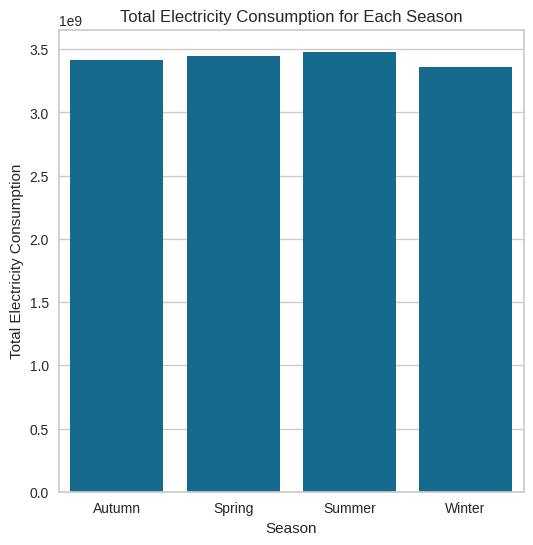

In [11]:
# Initialize an empty DataFrame to store the consumption data for each season
seasonal_consumption = pd.DataFrame()

# Loop through each building's DataFrame
for i in range(1277):
    j = i + 1
    df = dfs['df_' + str(j)]
    #df_1 = extract_time_elements(df, 1, 0.2)  # Adjust this function as per your implementation

    # Extract the total electricity consumption for each season
    seasonal_data = df_1.groupby('Season')['out.electricity.total.energy_consumption'].sum().reset_index()
    seasonal_consumption = pd.concat([seasonal_consumption, seasonal_data], ignore_index=True)

# Group by season and sum the electricity consumption
total_seasonal_consumption = seasonal_consumption.groupby('Season')['out.electricity.total.energy_consumption'].sum().reset_index()

# Plotting the data
plt.figure(figsize=(6, 6))
sns.barplot(x='Season', y='out.electricity.total.energy_consumption', data=total_seasonal_consumption, ci=None)
plt.title('Total Electricity Consumption for Each Season')
plt.xlabel('Season')
plt.ylabel('Total Electricity Consumption')
plt.show()

The total energy consumption appears to be consistent across all seasons with slight differences, indicating a relatively stable energy usage pattern throughout the year.





| Electricity Consumption | Season |
|-------------------------|--------|
|          Highest          | Summer |
|          Lowest          | Winter |



**Total Electricity Consumption for each month**

<ipython-input-12-624efa37fe63>:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Month', y='out.electricity.total.energy_consumption', data=total_monthly_consumption, ci=None)


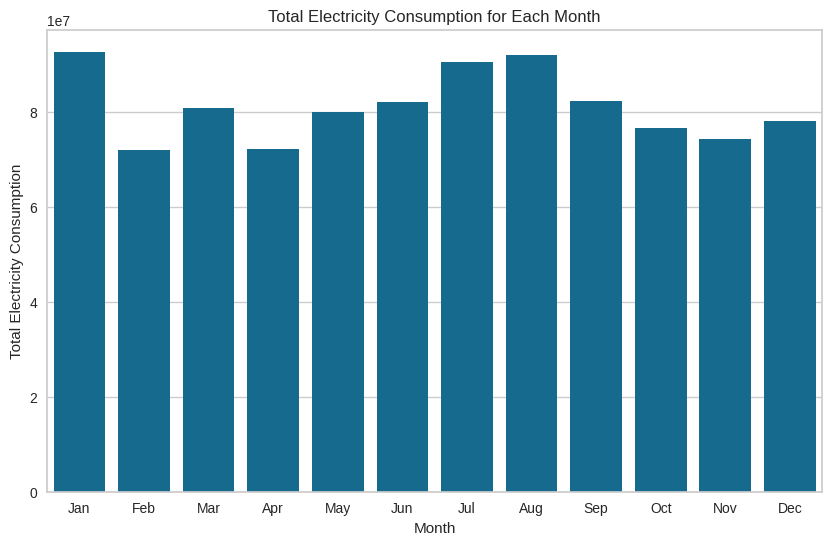

In [12]:
# Initialize an empty DataFrame to store the consumption data for each month
monthly_consumption = pd.DataFrame()

# Function to extract month from the date
def extract_month(df):
    df['Month'] = df['timestamp'].dt.month
    return df

# Loop through each building's DataFrame
for i in range(1277):
    j = i + 1
    df = dfs['df_' + str(j)]
    df = extract_month(df)  # Add a column for the month

    # Extract the total electricity consumption for each month
    monthly_data = df.groupby('Month')['out.electricity.total.energy_consumption'].sum().reset_index()
    monthly_consumption = pd.concat([monthly_consumption, monthly_data], ignore_index=True)

# Group by month and sum the electricity consumption
total_monthly_consumption = monthly_consumption.groupby('Month')['out.electricity.total.energy_consumption'].sum().reset_index()

# Plotting the data
plt.figure(figsize=(10, 6))
sns.barplot(x='Month', y='out.electricity.total.energy_consumption', data=total_monthly_consumption, ci=None)
plt.title('Total Electricity Consumption for Each Month')
plt.xlabel('Month')
plt.ylabel('Total Electricity Consumption')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()


| Electricity Consumption | Month |
|-------------------------|--------|
|          Highest          | January |
|          Lowest          | February |



**Electricity Consumption for each Day of the Week**

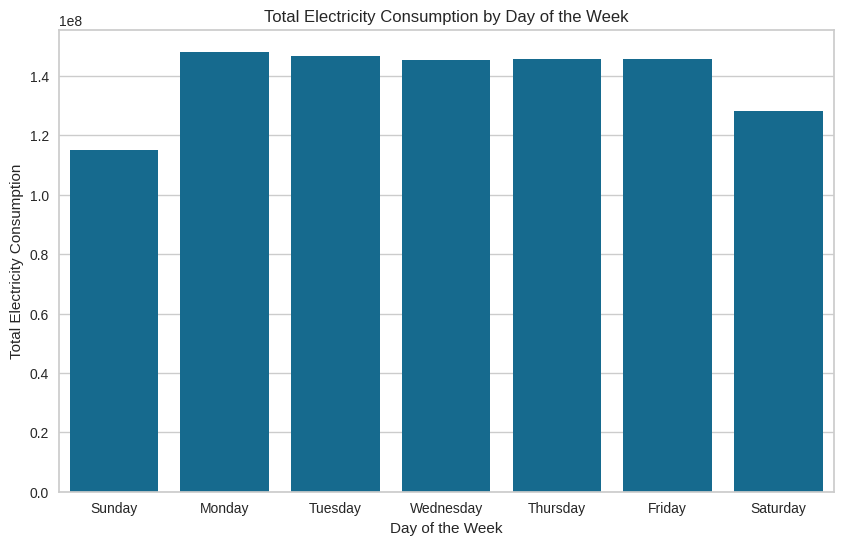

In [13]:
# Initialize an empty DataFrame to store the consumption data for each day of the week
daily_consumption = pd.DataFrame()

# Loop through each building's DataFrame
for i in range(1277):
    j = i + 1
    df = dfs['df_' + str(j)]

    # Extract the total electricity consumption for each day of the week
    df['Day_of_week'] = df['timestamp'].dt.day_name()
    daily_data = df.groupby('Day_of_week')['out.electricity.total.energy_consumption'].sum().reset_index()
    daily_consumption = pd.concat([daily_consumption, daily_data], ignore_index=True)

# Reorder days of the week
days_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
daily_consumption['Day_of_week'] = pd.Categorical(daily_consumption['Day_of_week'], categories=days_order, ordered=True)

# Group by day of the week and sum the electricity consumption
total_daily_consumption = daily_consumption.groupby('Day_of_week')['out.electricity.total.energy_consumption'].sum().reset_index()

# Plotting the data
plt.figure(figsize=(10, 6))
sns.barplot(x='Day_of_week', y='out.electricity.total.energy_consumption', data=total_daily_consumption)
plt.title('Total Electricity Consumption by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Electricity Consumption')
plt.show()


 The energy consumption across weekdays is approximately equal, indicating consistent usage patterns during the workweek. However, during weekends, the energy consumption tends to decrease noticeably compared to weekdays, suggesting a reduction in energy usage during non-working days.

| Electricity Consumption | Day |
|-------------------------|--------|
|          Highest          | Monday |
|          Lowest          | Sunday |



**Average Consumption per Hour by Time of Day**



| **Time of Day** | **Time Range**      |
|-----------------|---------------------|
| Morning         | 5 AM to 11 AM       |
| Afternoon       | 12 PM to 3 PM       |
| Evening         | 4 PM to 7 PM        |
| Night           | 8 PM to 4 AM        |

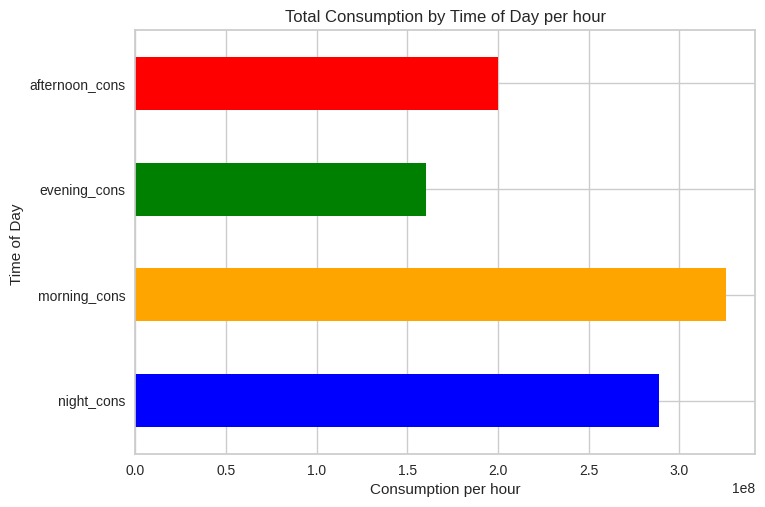

In [14]:
data = final_df[['night_cons', 'morning_cons', 'evening_cons', 'afternoon_cons']].sum().round(2)   # 9, 7, 4, 4
divisors = pd.Series([9, 7, 4, 4], index=['night_cons', 'morning_cons', 'evening_cons', 'afternoon_cons'])
# # Performing the division
result = data / divisors
# Plotting the bar chart
data.plot(kind='barh', color=['blue', 'orange', 'green', 'red'])
# Adding labels and title
plt.ylabel('Time of Day ')
plt.xlabel('Consumption per hour')
plt.title('Total Consumption by Time of Day per hour')
# Display the plot
plt.show()

| Electricity Consumption | Time Of Day |
|-------------------------|--------|
|          Highest          | Afternoon |
|          Lowest          | Night |



**Weekday Vs Weekend Average Energy Consumption**





| **Type** | **Days**      |
|-----------------|---------------------|
| Weekday        | Monday, Tuesday, Wednesday, Thursday, Friday       |
| Weekend       | Saturday, Sunday      |


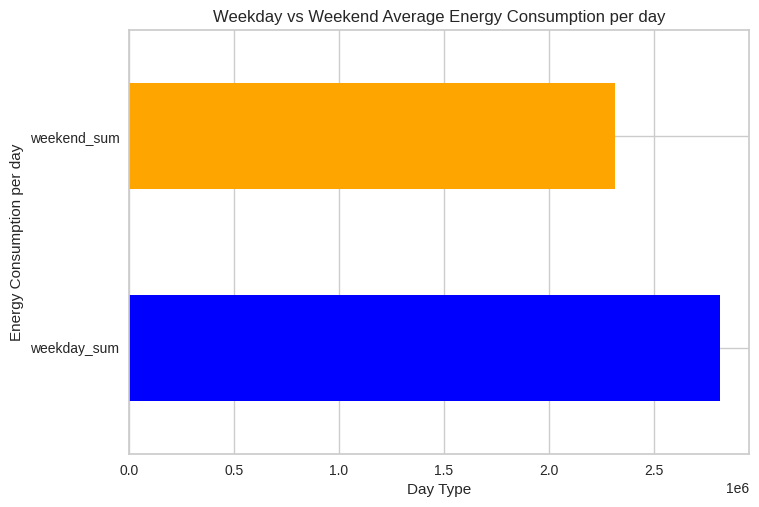

In [15]:
data = final_df[['weekday_sum', 'weekend_sum']].sum().round(2)
divisors = pd.Series([260, 105], index=['weekday_sum', 'weekend_sum'])
# Performing the division
result = data / divisors
# Plotting the bar chart
result.plot(kind='barh', color=['blue', 'orange'])
# Adding labels and title
plt.xlabel('Day Type')
plt.ylabel('Energy Consumption per day')
plt.title('Weekday vs Weekend Average Energy Consumption per day')
# Display the plot
plt.show()

| Electricity Consumption | Day Type |
|-------------------------|--------|
|          Highest          | Week Day |
|          Lowest          | Week End |



**Average Electricity Consumption for Holidays vs Non-Holidays**

Federal Holidays List of US

| Holiday                    | Date       |
|----------------------------|------------|
| New Year's Day             | January 1  |
| Martin Luther King Jr. Day | January 15 |
| Presidents' Day            | February 19|
| Memorial Day               | May 28     |
| Independence Day           | July 4     |
| Labor Day                  | September 3|
| Columbus Day               | October 8  |
| Veterans Day               | November 11|
| Thanksgiving Day           | November 22|
| Christmas Day              | December 25|

<ipython-input-16-602b93ba972c>:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=['Non-Holiday', 'Holiday'], y=[avg_non_holiday_consumption, avg_holiday_consumption], ci=None)


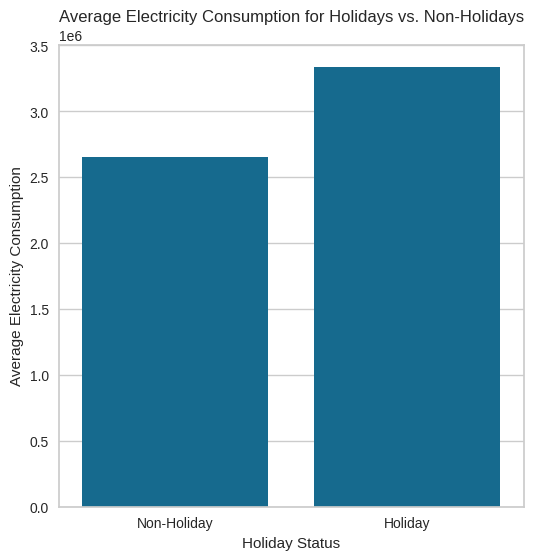

In [16]:
# Initialize an empty DataFrame to store the consumption data for each holiday status
holiday_consumption = pd.DataFrame()

# Loop through each building's DataFrame
for i in range(1277):
    j = i + 1
    df = dfs['df_' + str(j)]
    df['IsHoliday'] = df['timestamp'].apply(lambda x: 1 if x in us_holidays else 0)
    # Extract the total electricity consumption for holidays and non-holidays
    holiday_data = df.groupby('IsHoliday')['out.electricity.total.energy_consumption'].sum().reset_index()
    holiday_consumption = pd.concat([holiday_consumption, holiday_data], ignore_index=True)

# Group by holiday status and sum the electricity consumption
total_holiday_consumption = holiday_consumption.groupby('IsHoliday')['out.electricity.total.energy_consumption'].sum().reset_index()


# Calculate average electricity consumption for holidays and non-holidays
avg_holiday_consumption = total_holiday_consumption.loc[total_holiday_consumption['IsHoliday'] == 1, 'out.electricity.total.energy_consumption'].values[0] / 10
avg_non_holiday_consumption = total_holiday_consumption.loc[total_holiday_consumption['IsHoliday'] == 0, 'out.electricity.total.energy_consumption'].values[0] / 355

# Plotting the data
plt.figure(figsize=(6, 6))
sns.barplot(x=['Non-Holiday', 'Holiday'], y=[avg_non_holiday_consumption, avg_holiday_consumption], ci=None)
plt.title('Average Electricity Consumption for Holidays vs. Non-Holidays')
plt.xlabel('Holiday Status')
plt.ylabel('Average Electricity Consumption')
plt.show()



| Electricity Consumption | Holiday Status |
|-------------------------|--------|
|          Lowest          | Non-Holiday |
|          Highest          | Holiday |



# Clustering

We employed DBSCAN and K-means algorithms for clustering analysis. Although DBSCAN offered insights into the density-based structure of the data and is proficient at detecting outliers, K-means produced the most interpretable and well-defined clustering outcomes.

We create a data frame **final_df_copy** to use the features that explain distribution.

In [76]:
# We will use those features that explain distribution and save that dataframe in final_df_copy
final_df_copy = final_df[['Total_cons','Avg_cons','Median_cons','std','moving_mean_25','moving_mean_50','moving_mean_75','moving_mean_95','moving_mean_100','moving_median_25','moving_median_50',
                         'moving_median_75','moving_median_95','moving_median_100','expo_25','expo_50','expo_75','expo_95','expo_100','lag_25','lag_50','lag_75','lag_95','lag_100','winter_25','winter_50',
                         'winter_75','winter_100','summer_25','summer_50','summer_75','summer_100','autumn_25','autumn_50','autumn_75','autumn_100','spring_25','spring_50','spring_75','spring_100','p99-p1/p50',
                         'trimmed_mean','mean_abs_dev','median_abs_dev','mean/peak','trimmed_range','range','hourly_range','daily_range','weekly_range','day_of_week_range','monthly_range','monthly_avg',
                         'weekly_avg','daily_avg','hourly_avg','cons_10','cons_25','cons_50','cons_75','cons_90','cons_95','cons_100','hourly_10','hourly_25','hourly_50','hourly_75','hourly_90','hourly_95','hourly_100',
                         'daily_10','daily_25','daily_50','daily_75','daily_90','daily_95','daily_100','weekly_10','weekly_25','weekly_50','weekly_75','weekly_90','weekly_95','weekly_100','monthly_10','monthly_25','monthly_50',
                         'monthly_75','monthly_90','monthly_95','monthly_100']]

Robust Scaling of final_df_copy

In [77]:
# Scaling
rbst_scaler = RobustScaler() # We used robust scaler as we have some outliers in the data
final_df_copy = rbst_scaler.fit_transform(final_df_copy)

# DBSCAN

We utilise DBSCAN to group closely packed points into clusters and identify points in low-density areas as outliers. In DBSCAN, we have two parameters: ε (maximum distance for points to be neighbors) and MinPts (minimum points to form a cluster)

**Knee Plot**

knee plot visualizes distances to nearest neighbors, helping identify a significant change, known as the "knee" point. This point indicates the optimal parameter value for epsilon in DBSCAN, balancing cluster density and noise.







**Installing 'kneed' package**

In [78]:
!pip install kneed

Best epsilon value: 22.685694902332738


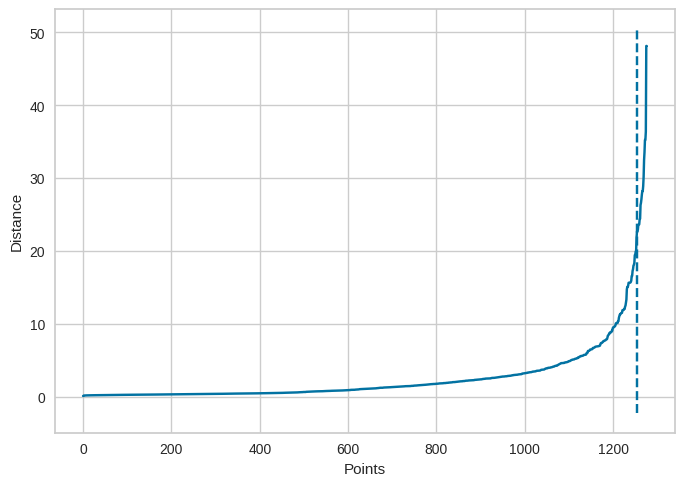

In [79]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Calculate the distance of each point to its nearest neighbor
nearest_neighbors = NearestNeighbors(n_neighbors=2)
distances, indices = nearest_neighbors.fit(final_df_copy).kneighbors(final_df_copy)

# Sort and plot the distances
distances = np.sort(distances, axis=0)
plt.plot(distances[:, 1])
plt.xlabel('Points')
plt.ylabel('Distance')

# Use KneeLocator to find the "knee" point, which indicates the optimal epsilon value
from kneed import KneeLocator
knee = KneeLocator(range(len(distances)), distances[:, 1], curve='convex', direction='increasing')
best_eps = distances[knee.elbow, 1]
print("Best epsilon value:", best_eps)

# Plot the knee point
plt.vlines(knee.elbow, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.show()


From the Knee Plot, we can identify the "knee point" which is marked on the distance curve. The Value of knee point is 22.685694902332738. Hence, we infer that the best epsilon value is 22.685694902332738.

**Utilization of Silhouette Score to determine min_samples value**

By computing the silhouette scores over a range of values (2, 10), we determine the optimal min_samples value.

In [80]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

# Initialize a list to store silhouette scores and corresponding min_samples values
silhouette_scores = []
min_samples_values = []

# Define a range of min_samples values to try
min_samples_range = range(2, 10)

# Iterate over each min_samples value
for min_samples in min_samples_range:
    # Initialize DBSCAN with the current min_samples value
    dbscan = DBSCAN(eps=best_eps, min_samples=min_samples)

    # Fit DBSCAN to the data and obtain cluster labels
    cluster_labels = dbscan.fit_predict(final_df_copy)

    # Calculate silhouette score
    silhouette_avg = silhouette_score(final_df_copy, cluster_labels)

    # Append silhouette score and corresponding min_samples value to the lists
    silhouette_scores.append(silhouette_avg)
    min_samples_values.append(min_samples)

    # Create a DataFrame from the lists
df_output = pd.DataFrame({'min_samples': min_samples_values, 'silhouette_score': silhouette_scores})

# Display the DataFrame
df_output



,min_samples,silhouette_score
0,2,0.702599
1,3,0.704724
2,4,0.848453
3,5,0.862095
4,6,0.849093
5,7,0.865058
6,8,0.866571
7,9,0.866318


From the silhouettee scores, to obtain lesser noise points we choose min_samples value as 4.

**Performing DBSCAN**

With epsilon value as 22.685694902332738 and min_samples as 4, we perform DBSCAN to obtain clusters and noise points.

In [81]:
# Initializing DBSCAN
dbscan = DBSCAN(eps=22.685694902332738, min_samples=4)

# Fitting DBSCAN to the scaled data
dbscan.fit(final_df_copy)

# saving the model
with open('dbscan_model.pkl', 'wb') as file:
    pickle.dump(dbscan, file)

# loading the model
with open('dbscan_model.pkl', 'rb') as file:
    dbscan = pickle.load(file)

# Getting cluster labels
cluster_labels = dbscan.labels_

# Printing the number of clusters and noise points
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters)
print('Estimated number of noise points: %d' % n_noise)

Estimated number of clusters: 2
Estimated number of noise points: 27


**Silhouette Plot**

Silhouette plot evaluates the quality of clusters by measuring how similar points are to their own cluster versus other clusters. It helps determine the appropriateness of clustering parameters.

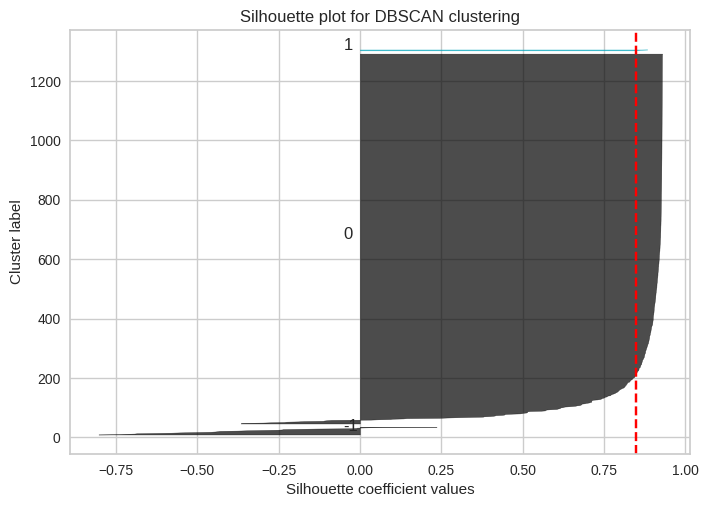

In [82]:
def plot_silhouette(X, cluster_labels):
    silhouette_avg = silhouette_score(X, cluster_labels)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in np.unique(cluster_labels):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / len(np.unique(cluster_labels)))
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.title("Silhouette plot for DBSCAN clustering")
    plt.xlabel("Silhouette coefficient values")
    plt.ylabel("Cluster label")

    plt.show()


model = DBSCAN(eps=22.685694902332738, min_samples=4)
cluster_labels = model.fit_predict(final_df_copy)

plot_silhouette(final_df_copy, cluster_labels)


The silhouette plot indicates that clusters are well-defined, but Cluster 0 is disproportionately large, diminishing the overall effectiveness of the clustering.

**PCA (2D)**

PCA (2D) reduces our high-dimensional data into two principal components, making it easier to visualize and clearly plots the structure of clusters and identifies noise points, aiding in the interpretation of DBSCAN results.

Estimated number of clusters: 2
Estimated number of noise points: 27


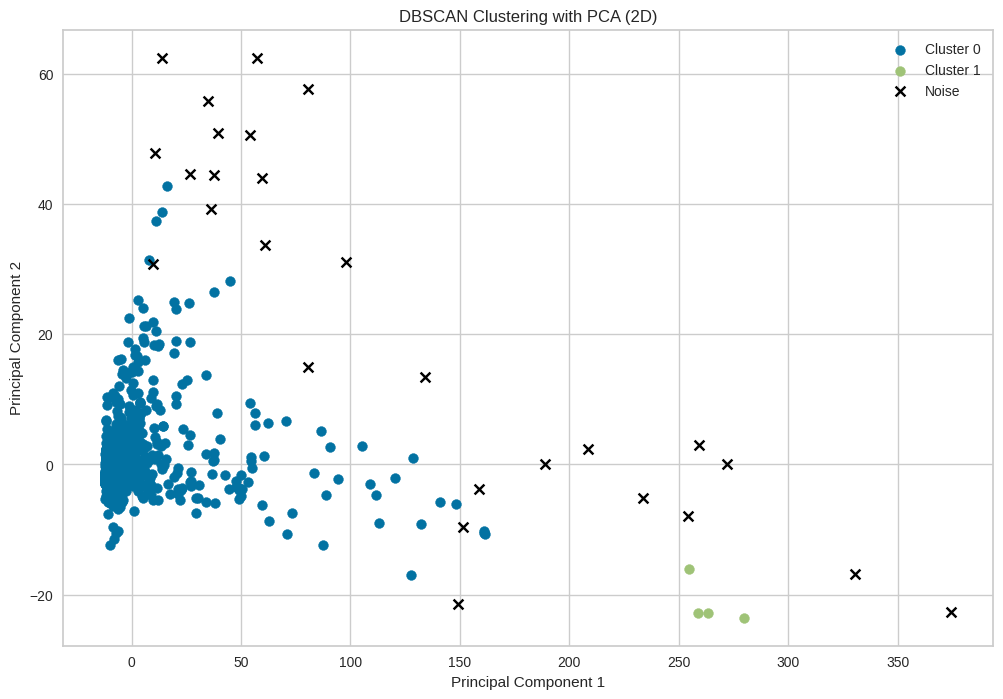

In [83]:
# Determine number of clusters and noise points
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters)
print('Estimated number of noise points: %d' % n_noise)

# Reduce dimensionality for visualization using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(final_df_copy)

# Create a DataFrame with the PCA results and the cluster labels
pca_df = pd.DataFrame(data=reduced_data, columns=['PC1', 'PC2'])
pca_df['Cluster'] = cluster_labels

# Plotting clusters and noise points
plt.figure(figsize=(12, 8))

# Plot each cluster
for cluster in range(n_clusters):
    cluster_data = pca_df[pca_df['Cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}', s=50)

# Plot noise points
noise_data = pca_df[pca_df['Cluster'] == -1]
plt.scatter(noise_data['PC1'], noise_data['PC2'], color='black', marker='x', label='Noise', s=50)

# Add labels and title
plt.title('DBSCAN Clustering with PCA (2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

**PCA(3D)**

PCA (3D) plot provides a more comprehensive view of the cluster structures and noise points, enhancing the interpretation of DBSCAN results.

Estimated number of clusters: 2
Estimated number of noise points: 27


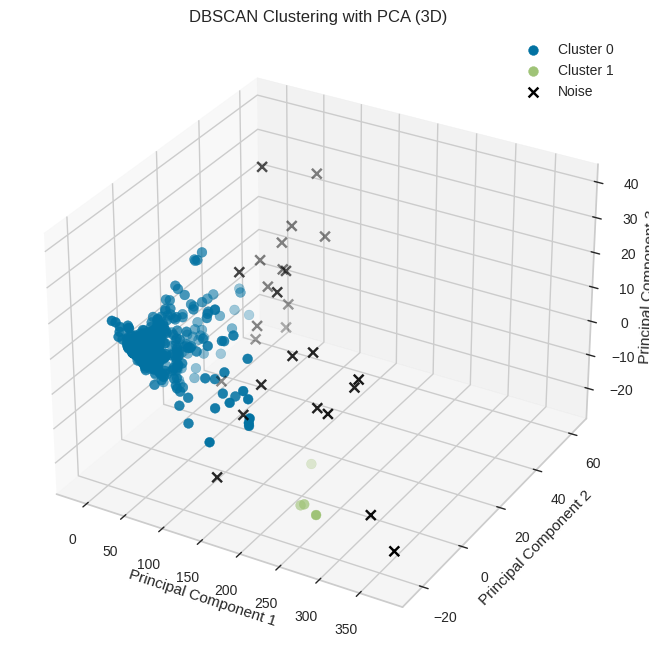

In [84]:
# Determine number of clusters and noise points
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters)
print('Estimated number of noise points: %d' % n_noise)

# Reduce dimensionality for visualization using PCA
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(final_df_copy)

# Create a DataFrame with the PCA results and the cluster labels
pca_df = pd.DataFrame(data=reduced_data, columns=['PC1', 'PC2', 'PC3'])
pca_df['Cluster'] = cluster_labels

# Plotting clusters and noise points
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each cluster
for cluster in range(n_clusters):
    cluster_data = pca_df[pca_df['Cluster'] == cluster]
    ax.scatter(cluster_data['PC1'], cluster_data['PC2'], cluster_data['PC3'], label=f'Cluster {cluster}', s=50)

# Plot noise points
noise_data = pca_df[pca_df['Cluster'] == -1]
ax.scatter(noise_data['PC1'], noise_data['PC2'], noise_data['PC3'], color='black', marker='x', label='Noise', s=50)

# Add labels and title
ax.set_title('DBSCAN Clustering with PCA (3D)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()
ax.grid(True)
plt.show()


**Building Count Of Each Cluster**

In [85]:
# Count the occurrences of each unique cluster label
counts = Counter(cluster_labels)

# Create a DataFrame from the counts
df_counts = pd.DataFrame.from_dict(counts, orient='index', columns=['Count'])

# Rename the index to 'Cluster'
df_counts.index.name = 'Cluster'

# Reset the index to make 'Cluster' a column
df_counts.reset_index(inplace=True)

# Display the DataFrame
df_counts


,Cluster,Count
0,0,1246
1,-1,27
2,1,4


**Upon evaluating the clustering results, it became evident that DBSCAN was not suitable for this dataset. The algorithm produced an uneven distribution of clusters and resulted in the formation of fewer clusters than anticipated. Due to these limitations and the suboptimal clustering performance, we decided to transition to the KMeans algorithm. KMeans is expected to yield better clustering results with a more balanced and appropriate number of clusters, thereby improving the overall productivity and effectiveness of the clustering process.**

# KMeans


We will implement the KMeans algorithm with a range of cluster numbers (2,14) to identify the optimal number of clusters that best represent the underlying structure of the data. For each value of cluster within the range, we calculate the inertia and silhouette scores, which serve as metrics for evaluating the clustering performance.

**Elbow Method**:

To determine the optimal number of clusters, we utilize the elbow method by plotting the inertia values against the number of clusters. The following code scales a dataset using RobustScaler, then iterates through cluster numbers (2-14) to perform KMeans clustering, storing inertia and silhouette scores, and plots the elbow curve.



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

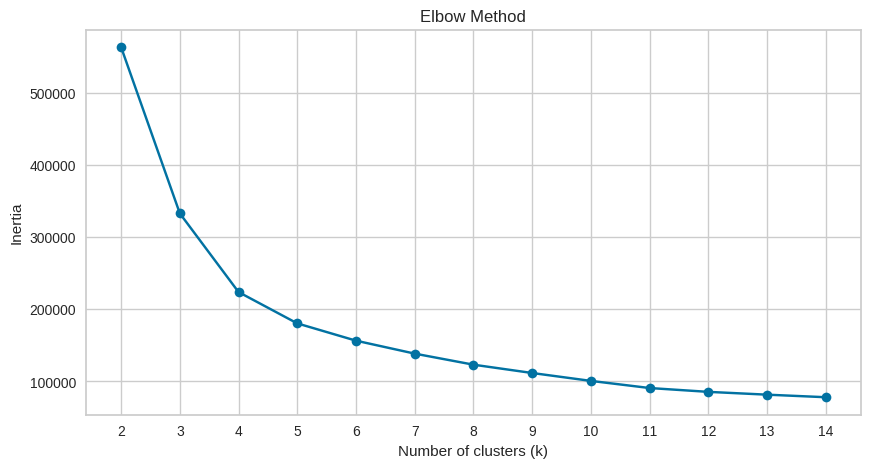

In [86]:
# Defining a range of cluster numbers to try

k_values = range(2, 15)

# Initializing the lists to store the inertia and silhouette scores for each k
inertia_values = []
silhouette_scores = []

# We will use those features that explain distribution and save that dataframe in final_df_copy
final_df_copy = final_df[['Total_cons','Avg_cons','Median_cons','std','moving_mean_25','moving_mean_50','moving_mean_75','moving_mean_95','moving_mean_100','moving_median_25','moving_median_50',
                         'moving_median_75','moving_median_95','moving_median_100','expo_25','expo_50','expo_75','expo_95','expo_100','lag_25','lag_50','lag_75','lag_95','lag_100','winter_25','winter_50',
                         'winter_75','winter_100','summer_25','summer_50','summer_75','summer_100','autumn_25','autumn_50','autumn_75','autumn_100','spring_25','spring_50','spring_75','spring_100','p99-p1/p50',
                         'trimmed_mean','mean_abs_dev','median_abs_dev','mean/peak','trimmed_range','range','hourly_range','daily_range','weekly_range','day_of_week_range','monthly_range','monthly_avg',
                         'weekly_avg','daily_avg','hourly_avg','cons_10','cons_25','cons_50','cons_75','cons_90','cons_95','cons_100','hourly_10','hourly_25','hourly_50','hourly_75','hourly_90','hourly_95','hourly_100',
                         'daily_10','daily_25','daily_50','daily_75','daily_90','daily_95','daily_100','weekly_10','weekly_25','weekly_50','weekly_75','weekly_90','weekly_95','weekly_100','monthly_10','monthly_25','monthly_50',
                         'monthly_75','monthly_90','monthly_95','monthly_100']]


# Scaling
rbst_scaler = RobustScaler() # We used robust scaler as we have some outliers in the data
final_df_copy = rbst_scaler.fit_transform(final_df_copy)

# Iterating over each k value
for k in k_values:
    # Initializing KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=42)

    # Fitting KMeans to the data
    kmeans.fit(final_df_copy)

    # Append the inertia and silhouette score for this k value
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(final_df_copy, kmeans.labels_))

# Plot the elbow curve
plt.figure(figsize=(10, 5))
plt.plot(k_values, inertia_values, marker='o', linestyle='-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)
plt.show()

The last steep fall in the above graph is at cluster 4. Now we will visualize volume of data points in each cluster and average silhouette score when we will take number of clusters as 4.

**Silhouette Visualizar**

The Silhouette Visualizer displays the silhouette coefficient for each sample on a per-cluster basis, visualizing which clusters are dense and which are not.
It also displayes average silhouette score.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


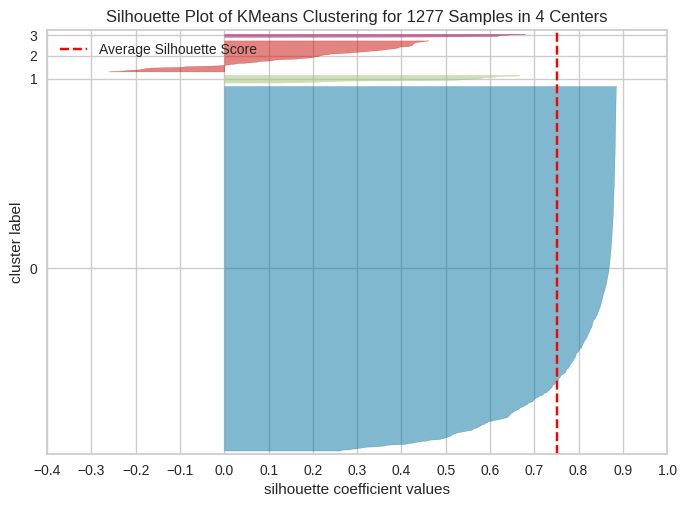

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 1277 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [87]:
model = KMeans(4, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(final_df_copy)        # Fit the data to the visualizer
visualizer.show()

Upon analysis, the elbow method suggests that the optimal number of clusters for our dataset is 4.
From Silhouette Visualizer we can infer that cluster 0 will contain maximum data points while cluster 3 will contain least. This clustering can make sense if we have maximum buildings sharing same energy consumption pattern.
The Silhouette score obtained 0.75 at 4 clusters indicates better-defined clusters, well-separated clusters. Also, 4 clusters is better in profiling point of view too.

Since, we have obtained optimal cluster count as 4, we fit the cluster labels to final_df as 'Cluster' column

In [88]:
# Since, we can see that the last steep fall is at cluster 4, we will make four clusters.

final_df_copy = final_df[['Total_cons','Avg_cons','Median_cons','std','moving_mean_25','moving_mean_50','moving_mean_75','moving_mean_95','moving_mean_100','moving_median_25','moving_median_50',
                         'moving_median_75','moving_median_95','moving_median_100','expo_25','expo_50','expo_75','expo_95','expo_100','lag_25','lag_50','lag_75','lag_95','lag_100','winter_25','winter_50',
                         'winter_75','winter_100','summer_25','summer_50','summer_75','summer_100','autumn_25','autumn_50','autumn_75','autumn_100','spring_25','spring_50','spring_75','spring_100','p99-p1/p50',
                         'trimmed_mean','mean_abs_dev','median_abs_dev','mean/peak','trimmed_range','range','hourly_range','daily_range','weekly_range','day_of_week_range','monthly_range','monthly_avg',
                         'weekly_avg','daily_avg','hourly_avg','cons_10','cons_25','cons_50','cons_75','cons_90','cons_95','cons_100','hourly_10','hourly_25','hourly_50','hourly_75','hourly_90','hourly_95','hourly_100',
                         'daily_10','daily_25','daily_50','daily_75','daily_90','daily_95','daily_100','weekly_10','weekly_25','weekly_50','weekly_75','weekly_90','weekly_95','weekly_100','monthly_10','monthly_25','monthly_50',
                         'monthly_75','monthly_90','monthly_95','monthly_100']]


# Scaling
rbst_scaler = RobustScaler()
final_df_copy = rbst_scaler.fit_transform(final_df_copy)

# Initializing KMeans model
kmeans = KMeans(n_clusters=4, random_state=42)

# Fitting KMeans model to the data
kmeans.fit(final_df_copy)

# saving the model
with open('kmeans_model_1.pkl', 'wb') as file:
    pickle.dump(kmeans, file)

# loading the model
with open('kmeans_model_1.pkl', 'rb') as file:
    kmeans = pickle.load(file)

cluster_label = kmeans.labels_

# Adding cluster labels to the final_df dataframe
final_df['Cluster'] = kmeans.labels_

# Calculating silhouette score
silhouette_avg = silhouette_score(final_df_copy, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

# Printing DataFrame with cluster labels
final_df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.7510357954362349


,ID,Total_cons,Avg_cons,Median_cons,weekday_sum,weekend_sum,weekday_peak,weekend_peak,which_season_peak,peak_season_cons,...,summer_100,autumn_25,autumn_50,autumn_75,autumn_100,spring_25,spring_50,spring_75,spring_100,Cluster
0,1,24087.947,0.687422,0.612,17331.769,6756.178,257.774,221.336,Winter,9085.557,...,1.925,0.384,0.531,0.70300,2.239,0.46300,0.608,0.75400,2.622,0
0,2,2460.349,0.070213,0.062,1783.170,677.179,19.423,13.422,Summer,781.687,...,0.277,0.032,0.045,0.07100,0.270,0.03700,0.044,0.06800,0.290,0
0,3,944.900,0.026966,0.015,716.190,228.710,12.322,17.196,Summer,428.198,...,0.468,0.012,0.013,0.01800,0.389,0.01300,0.015,0.02200,0.130,0
0,4,10561.361,0.301400,0.184,7535.563,3025.798,40.797,51.434,Winter,2872.404,...,2.225,0.117,0.168,0.33600,2.092,0.11400,0.168,0.35325,2.073,0
0,5,17796.474,0.507876,0.433,12680.430,5116.044,181.737,189.635,Winter,6434.691,...,3.208,0.262,0.370,0.49825,2.841,0.31275,0.434,0.57600,2.837,0


**PCA(2D):**

PCA is conducted to visualize the data in a lower-dimensional space, aiding in the interpretation of the data's underlying structure across four clusters with 2 components.

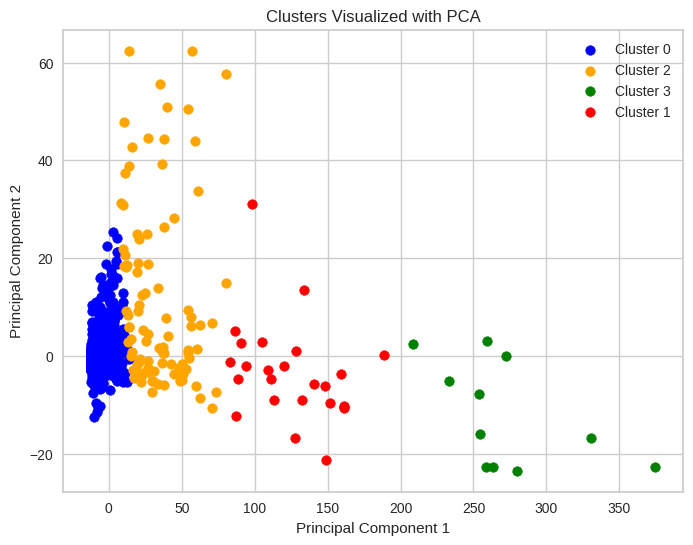

In [89]:
# Initializing PCA with 2 components
pca = PCA(n_components=2)

# Fitting PCA to the scaled data
pca.fit(final_df_copy)

# Transforming the data to the new coordinate system defined by the first two principal components
df_pca = pca.transform(final_df_copy)

# Plotting the clusters
plt.figure(figsize=(8, 6))
colors = ['blue', 'orange', 'green', 'red']


cluster_labels = final_df['Cluster'].unique()

for i, cluster_label in enumerate(cluster_labels):

    # Selecting data points belonging to the current cluster
    cluster_data = df_pca[final_df['Cluster'] == cluster_label]

    # Ploting data points for the current cluster
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster_label}', color=colors[i])


plt.title('Clusters Visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

**PCA(3D):**

By conducting PCA with three components in this code, we aim to explore the data's structure in a more comprehensive manner, leveraging additional dimensions to potentially capture more variance and intricate patterns within the data.

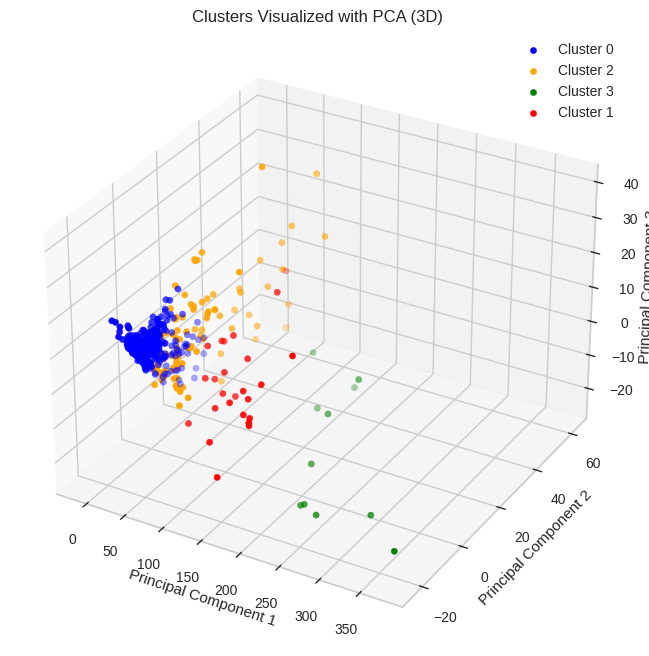

In [90]:
# Initializing PCA with 3 components
pca = PCA(n_components=3)

# Fitting PCA to the scaled data
pca.fit(final_df_copy)

# Transforming the data to the new coordinate system defined by the first three principal components
df_pca = pca.transform(final_df_copy)

# Plotting the clusters in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['blue', 'orange', 'green', 'red']

cluster_labels = final_df['Cluster'].unique()

for i, cluster_label in enumerate(cluster_labels):

    # Selecting data points belonging to the current cluster
    cluster_data = df_pca[final_df['Cluster'] == cluster_label]

    # Ploting data points for the current cluster
    ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], label=f'Cluster {cluster_label}', color=colors[i])

ax.set_title('Clusters Visualized with PCA (3D)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()
plt.show()


**Building Count for Each Cluster**

In [91]:
# Number of building in each cluster

pd.DataFrame(final_df['Cluster'].value_counts()).reset_index()

,Cluster,count
0,0,1143
1,2,98
2,1,25
3,3,11


**Based on the building distribution, we observe that cluster 0 contains 90% of the buildings. Therefore, we will create subclusters within cluster 0 and will try to find if the subclusters have any distinctive pattern from each other or not.**

## Clustering of Cluster 0

**Defining a dataframe for cluster 0**

In [92]:
# Defining a dataframe for cluster 0

cluster_0_df = final_df[final_df['Cluster'] == 0]

**Elbow Method for Cluster 0**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

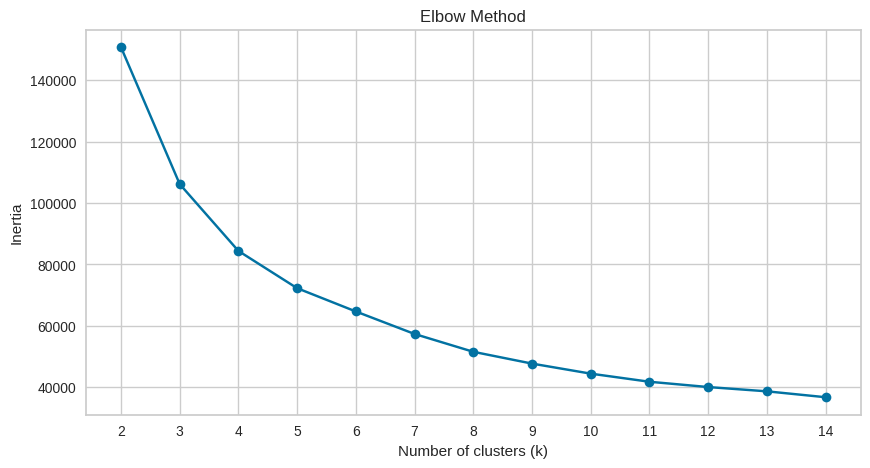

In [93]:
# Defining a range of cluster numbers to try
k_values = range(2, 15)

# Initializing lists to store the inertia and silhouette scores for each k
inertia_values = []
silhouette_scores = []

final_df_copy = cluster_0_df[['Total_cons','Avg_cons','Median_cons','std','moving_mean_25','moving_mean_50','moving_mean_75','moving_mean_95','moving_mean_100','moving_median_25','moving_median_50',
                         'moving_median_75','moving_median_95','moving_median_100','expo_25','expo_50','expo_75','expo_95','expo_100','lag_25','lag_50','lag_75','lag_95','lag_100','winter_25','winter_50',
                         'winter_75','winter_100','summer_25','summer_50','summer_75','summer_100','autumn_25','autumn_50','autumn_75','autumn_100','spring_25','spring_50','spring_75','spring_100','p99-p1/p50',
                         'trimmed_mean','mean_abs_dev','median_abs_dev','mean/peak','trimmed_range','range','hourly_range','daily_range','weekly_range','day_of_week_range','monthly_range','monthly_avg',
                         'weekly_avg','daily_avg','hourly_avg','cons_10','cons_25','cons_50','cons_75','cons_90','cons_95','cons_100','hourly_10','hourly_25','hourly_50','hourly_75','hourly_90','hourly_95','hourly_100',
                         'daily_10','daily_25','daily_50','daily_75','daily_90','daily_95','daily_100','weekly_10','weekly_25','weekly_50','weekly_75','weekly_90','weekly_95','weekly_100','monthly_10','monthly_25','monthly_50',
                         'monthly_75','monthly_90','monthly_95','monthly_100']]



# Scaling
rbst_scaler = RobustScaler()
final_df_copy = rbst_scaler.fit_transform(final_df_copy)

# Iterating over each k value
for k in k_values:
    # Initializing KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=42)

    # Fitting KMeans to the data
    kmeans.fit(final_df_copy)

    # Appending the inertia and silhouette score for this k value
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(final_df_copy, kmeans.labels_))

# Ploting the elbow curve
plt.figure(figsize=(10, 5))
plt.plot(k_values, inertia_values, marker='o', linestyle='-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)
plt.show()

We will fit sihouette visualizer for number of clusters at 3.

**Silhouette Visualizar**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


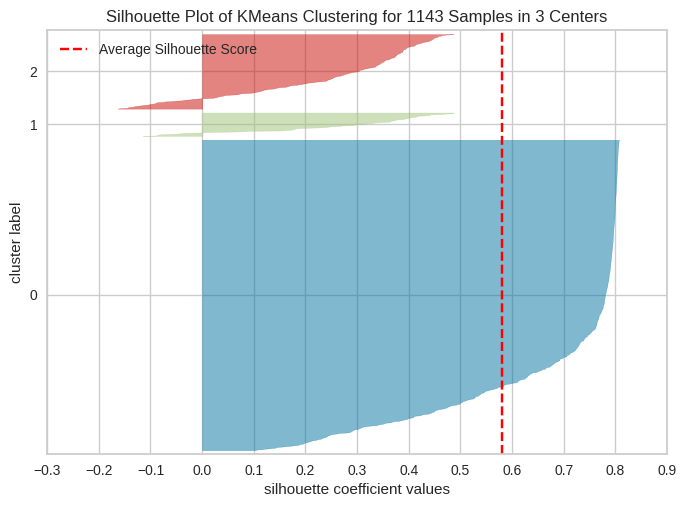

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 1143 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [94]:
model = KMeans(3, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(final_df_copy)        # Fit the data to the visualizer
visualizer.show()

Upon analysis, the elbow method suggests that the optimal number of clusters for our dataset is 3.
From Silhouette Visualizer we can infer that cluster 0 will contain maximum data points.
The Silhouette score obtained 0.58 at 3 clusters.
Since, we want to limit our clusters, we decide to take subclustering at number of clusters as 3. Now we will have 6 clusters in total.

**Performing KMeans for Cluster 0**

In [95]:
# We will make 3 clusters this time because we want to limit our number of clusters.

final_df_copy = cluster_0_df[['Total_cons','Avg_cons','Median_cons','std','moving_mean_25','moving_mean_50','moving_mean_75','moving_mean_95','moving_mean_100','moving_median_25','moving_median_50',
                         'moving_median_75','moving_median_95','moving_median_100','expo_25','expo_50','expo_75','expo_95','expo_100','lag_25','lag_50','lag_75','lag_95','lag_100','winter_25','winter_50',
                         'winter_75','winter_100','summer_25','summer_50','summer_75','summer_100','autumn_25','autumn_50','autumn_75','autumn_100','spring_25','spring_50','spring_75','spring_100','p99-p1/p50',
                         'trimmed_mean','mean_abs_dev','median_abs_dev','mean/peak','trimmed_range','range','hourly_range','daily_range','weekly_range','day_of_week_range','monthly_range','monthly_avg',
                         'weekly_avg','daily_avg','hourly_avg','cons_10','cons_25','cons_50','cons_75','cons_90','cons_95','cons_100','hourly_10','hourly_25','hourly_50','hourly_75','hourly_90','hourly_95','hourly_100',
                         'daily_10','daily_25','daily_50','daily_75','daily_90','daily_95','daily_100','weekly_10','weekly_25','weekly_50','weekly_75','weekly_90','weekly_95','weekly_100','monthly_10','monthly_25','monthly_50',
                         'monthly_75','monthly_90','monthly_95','monthly_100']]


# Scaling
rbst_scaler = RobustScaler()
final_df_copy = rbst_scaler.fit_transform(final_df_copy)

# Initializing KMeans model
kmeans = KMeans(n_clusters=3, random_state=42)

# Fitting KMeans model to the data
kmeans.fit(final_df_copy)

# saving the model
with open('kmeans_model_2.pkl', 'wb') as file:
    pickle.dump(kmeans, file)

# # # loading the model
# with open('kmeans_model_2.pkl', 'rb') as file:
#     kmeans = pickle.load(file)

cluster_label = kmeans.labels_


# Adding cluster labels to the DataFrame
cluster_0_df['Cluster'] = kmeans.labels_
silhouette_avg = silhouette_score(final_df_copy, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

# Printing DataFrame with cluster labels
cluster_0_df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.5804391999905348


<ipython-input-95-f3d27e81712e>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_0_df['Cluster'] = kmeans.labels_


,ID,Total_cons,Avg_cons,Median_cons,weekday_sum,weekend_sum,weekday_peak,weekend_peak,which_season_peak,peak_season_cons,...,summer_100,autumn_25,autumn_50,autumn_75,autumn_100,spring_25,spring_50,spring_75,spring_100,Cluster
0,1,24087.947,0.687422,0.612,17331.769,6756.178,257.774,221.336,Winter,9085.557,...,1.925,0.384,0.531,0.70300,2.239,0.46300,0.608,0.75400,2.622,0
0,2,2460.349,0.070213,0.062,1783.170,677.179,19.423,13.422,Summer,781.687,...,0.277,0.032,0.045,0.07100,0.270,0.03700,0.044,0.06800,0.290,0
0,3,944.900,0.026966,0.015,716.190,228.710,12.322,17.196,Summer,428.198,...,0.468,0.012,0.013,0.01800,0.389,0.01300,0.015,0.02200,0.130,0
0,4,10561.361,0.301400,0.184,7535.563,3025.798,40.797,51.434,Winter,2872.404,...,2.225,0.117,0.168,0.33600,2.092,0.11400,0.168,0.35325,2.073,0
0,5,17796.474,0.507876,0.433,12680.430,5116.044,181.737,189.635,Winter,6434.691,...,3.208,0.262,0.370,0.49825,2.841,0.31275,0.434,0.57600,2.837,0


**PCA(2D) of Cluster 0**

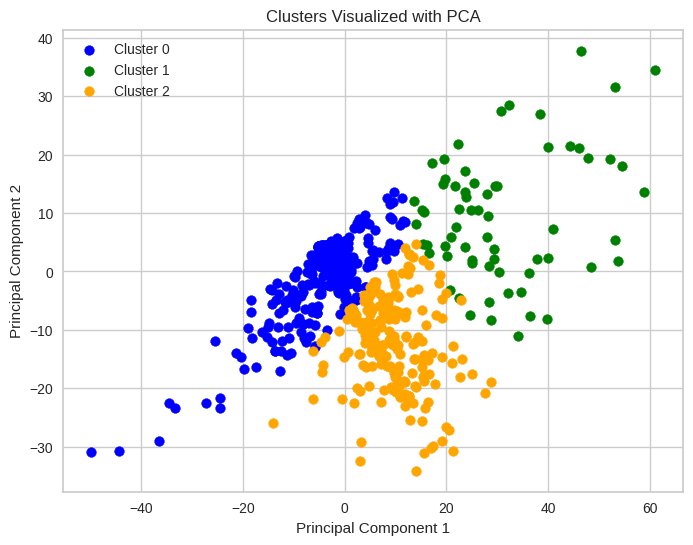

In [96]:
# Initializing PCA with 2 components
pca = PCA(n_components=2)

# Fiting PCA to the scaled data
pca.fit(final_df_copy)

# Transforming the data to the new coordinate system defined by the first two principal components
df_pca = pca.transform(final_df_copy)

# Plotting the clusters
plt.figure(figsize=(8, 6))
colors = ['blue','green', 'orange']


cluster_labels = cluster_0_df['Cluster'].unique()

for i, cluster_label in enumerate(cluster_labels):

    # Selecting data points belonging to the current cluster
    cluster_data = df_pca[cluster_0_df['Cluster'] == cluster_label]

    # Plotting data points for the current cluster
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster_label}', color=colors[i])


plt.title('Clusters Visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

**PCA(3D) of Cluster 0**

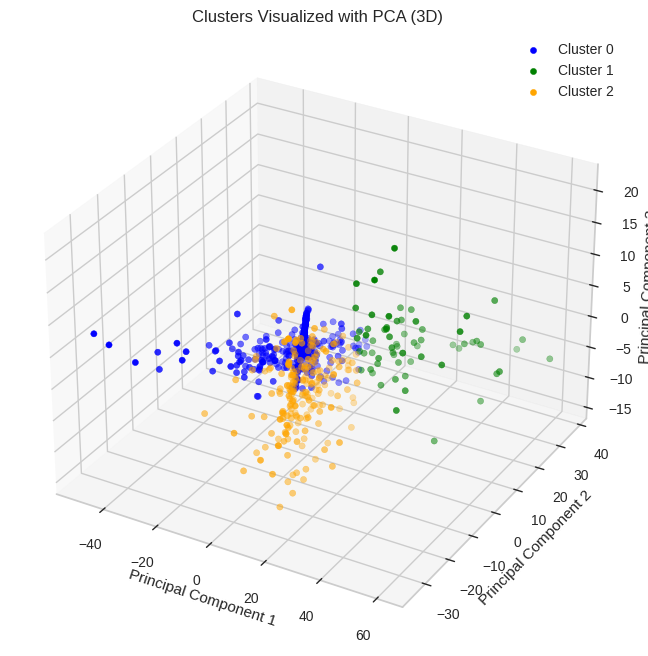

In [97]:
# Initializing PCA with 3 components
pca = PCA(n_components=3)

# Fitting PCA to the scaled data
pca.fit(final_df_copy)

# Transforming the data to the new coordinate system defined by the first three principal components
df_pca = pca.transform(final_df_copy)

# Plotting the clusters in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['blue', 'green', 'orange']

cluster_labels = cluster_0_df['Cluster'].unique()

for i, cluster_label in enumerate(cluster_labels):

    # Selecting data points belonging to the current cluster
    cluster_data = df_pca[cluster_0_df['Cluster'] == cluster_label]

    # Ploting data points for the current cluster
    ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], label=f'Cluster {cluster_label}', color=colors[i])

ax.set_title('Clusters Visualized with PCA (3D)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()
plt.show()


**Building Count within Sub-Clusters of Cluster 0**

In [98]:
# Number of building in each cluster 0

pd.DataFrame(cluster_0_df['Cluster'].value_counts()).reset_index()

,Cluster,count
0,0,868
1,2,209
2,1,66


# Visualizing all clusters together

Clubbing all 6 clusters (3 main clusters and 3 sub clusters) in one column

In [40]:
final_remaining = final_df[final_df['Cluster'] != 0]
cluster_0_df['Cluster'] = cluster_0_df['Cluster'].replace({0: '0a', 1: '0b', 2: '0c'})
clustered_data = pd.concat([final_remaining, cluster_0_df], axis=0)
clustered_data['Cluster'] = clustered_data['Cluster'].astype(str)
label_encoder = LabelEncoder()
clustered_data['Cluster_encoded'] = label_encoder.fit_transform(clustered_data['Cluster'])
clustered_data.sort_values(by = 'ID').head()

<ipython-input-40-dca3c420751a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_0_df['Cluster'] = cluster_0_df['Cluster'].replace({0: '0a', 1: '0b', 2: '0c'})


,ID,Total_cons,Avg_cons,Median_cons,weekday_sum,weekend_sum,weekday_peak,weekend_peak,which_season_peak,peak_season_cons,...,autumn_25,autumn_50,autumn_75,autumn_100,spring_25,spring_50,spring_75,spring_100,Cluster,Cluster_encoded
0,1,24087.947,0.687422,0.612,17331.769,6756.178,257.774,221.336,Winter,9085.557,...,0.384,0.531,0.70300,2.239,0.46300,0.608,0.75400,2.622,0a,0
0,2,2460.349,0.070213,0.062,1783.170,677.179,19.423,13.422,Summer,781.687,...,0.032,0.045,0.07100,0.270,0.03700,0.044,0.06800,0.290,0a,0
0,3,944.900,0.026966,0.015,716.190,228.710,12.322,17.196,Summer,428.198,...,0.012,0.013,0.01800,0.389,0.01300,0.015,0.02200,0.130,0a,0
0,4,10561.361,0.301400,0.184,7535.563,3025.798,40.797,51.434,Winter,2872.404,...,0.117,0.168,0.33600,2.092,0.11400,0.168,0.35325,2.073,0a,0
0,5,17796.474,0.507876,0.433,12680.430,5116.044,181.737,189.635,Winter,6434.691,...,0.262,0.370,0.49825,2.841,0.31275,0.434,0.57600,2.837,0a,0


2D Visualization of all 6 clusters

<ipython-input-41-027bbaf2dbad>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['Cluster'] = temp_df['Cluster']


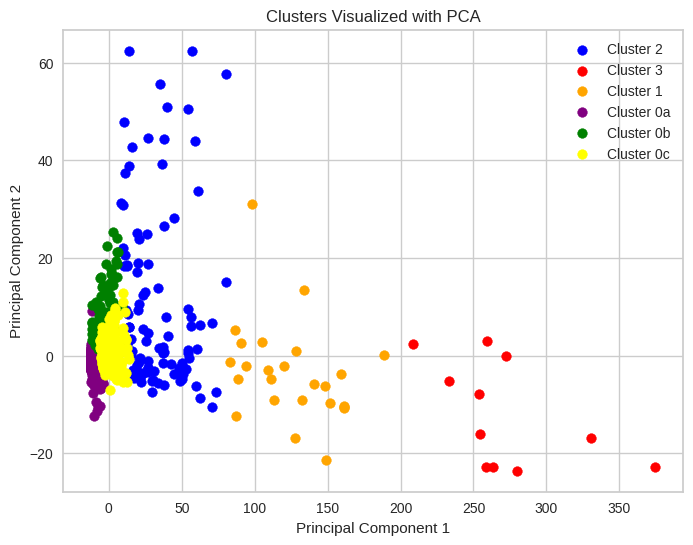

In [41]:
result_df = clustered_data[['Total_cons','Avg_cons','Median_cons','std','moving_mean_25','moving_mean_50','moving_mean_75','moving_mean_95','moving_mean_100','moving_median_25','moving_median_50',
                         'moving_median_75','moving_median_95','moving_median_100','expo_25','expo_50','expo_75','expo_95','expo_100','lag_25','lag_50','lag_75','lag_95','lag_100','winter_25','winter_50',
                         'winter_75','winter_100','summer_25','summer_50','summer_75','summer_100','autumn_25','autumn_50','autumn_75','autumn_100','spring_25','spring_50','spring_75','spring_100','p99-p1/p50',
                         'trimmed_mean','mean_abs_dev','median_abs_dev','mean/peak','trimmed_range','range','hourly_range','daily_range','weekly_range','day_of_week_range','monthly_range','monthly_avg',
                         'weekly_avg','daily_avg','hourly_avg','cons_10','cons_25','cons_50','cons_75','cons_90','cons_95','cons_100','hourly_10','hourly_25','hourly_50','hourly_75','hourly_90','hourly_95','hourly_100',
                         'daily_10','daily_25','daily_50','daily_75','daily_90','daily_95','daily_100','weekly_10','weekly_25','weekly_50','weekly_75','weekly_90','weekly_95','weekly_100','monthly_10','monthly_25','monthly_50',
                         'monthly_75','monthly_90','monthly_95','monthly_100', 'Cluster_encoded']]

temp_df = clustered_data[['Cluster']]

# Scaling
result_scaled = rbst_scaler.fit_transform(result_df)

# Initializing PCA with 2 components
pca = PCA(n_components=2)

# Fiting PCA to the scaled data
pca.fit(result_scaled)

# Transforming the data to the new coordinate system defined by the first two principal components
df_pca = pca.transform(result_scaled)

# Plotting the clusters
plt.figure(figsize=(8, 6))
colors = ['blue','red', 'orange', 'purple', 'green', 'yellow']

result_df['Cluster'] = temp_df['Cluster']
cluster_labels = result_df['Cluster'].unique()

for i, cluster_label in enumerate(cluster_labels):

    # Selecting data points belonging to the current cluster
    cluster_data = df_pca[result_df['Cluster'] == cluster_label]

    # Plotting data points for the current cluster
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster_label}', color=colors[i])


plt.title('Clusters Visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

3D Visualization of all 6 clusters

<ipython-input-42-6ed9530b514f>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['Cluster'] = temp_df['Cluster']


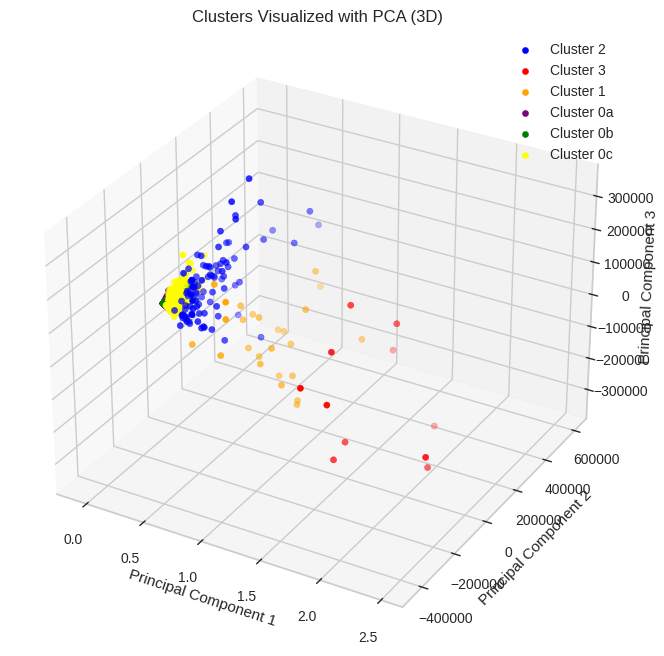

In [42]:
result_df = clustered_data[['Total_cons','Avg_cons','Median_cons','std','moving_mean_25','moving_mean_50','moving_mean_75','moving_mean_95','moving_mean_100','moving_median_25','moving_median_50',
                         'moving_median_75','moving_median_95','moving_median_100','expo_25','expo_50','expo_75','expo_95','expo_100','lag_25','lag_50','lag_75','lag_95','lag_100','winter_25','winter_50',
                         'winter_75','winter_100','summer_25','summer_50','summer_75','summer_100','autumn_25','autumn_50','autumn_75','autumn_100','spring_25','spring_50','spring_75','spring_100','p99-p1/p50',
                         'trimmed_mean','mean_abs_dev','median_abs_dev','mean/peak','trimmed_range','range','hourly_range','daily_range','weekly_range','day_of_week_range','monthly_range','monthly_avg',
                         'weekly_avg','daily_avg','hourly_avg','cons_10','cons_25','cons_50','cons_75','cons_90','cons_95','cons_100','hourly_10','hourly_25','hourly_50','hourly_75','hourly_90','hourly_95','hourly_100',
                         'daily_10','daily_25','daily_50','daily_75','daily_90','daily_95','daily_100','weekly_10','weekly_25','weekly_50','weekly_75','weekly_90','weekly_95','weekly_100','monthly_10','monthly_25','monthly_50',
                         'monthly_75','monthly_90','monthly_95','monthly_100', 'Cluster_encoded']]

temp_df = clustered_data[['Cluster']]


# Initializing PCA with 3 components
pca = PCA(n_components=3)

# Fitting PCA to the scaled data
pca.fit(result_df)

# Transforming the data to the new coordinate system defined by the first three principal components
df_pca = pca.transform(result_df)

# Plotting the clusters in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['blue','red', 'orange', 'purple', 'green', 'yellow']

result_df['Cluster'] = temp_df['Cluster']
cluster_labels = result_df['Cluster'].unique()

for i, cluster_label in enumerate(cluster_labels):

    # Selecting data points belonging to the current cluster
    cluster_data = df_pca[result_df['Cluster'] == cluster_label]

    # Ploting data points for the current cluster
    ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], label=f'Cluster {cluster_label}', color=colors[i])

ax.set_title('Clusters Visualized with PCA (3D)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()
plt.show()


# Profiling

**Consumption per building for Each Cluster (Median)**

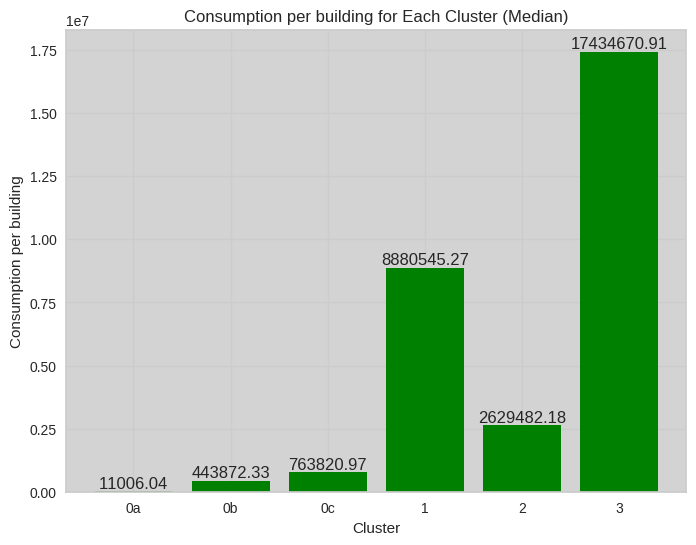

In [43]:
total_cons_median = clustered_data.groupby(['Cluster'], as_index = False)[['Total_cons']].median()

# Plotting
plt.figure(figsize=(8, 6))
bars = plt.bar(total_cons_median['Cluster'], total_cons_median['Total_cons'], color='green')
plt.xlabel('Cluster')
plt.ylabel('Consumption per building')
plt.title('Consumption per building for Each Cluster (Median)')
plt.xticks(total_cons_median['Cluster'])
plt.gca().set_facecolor('lightgrey')

# Adding bar numbers
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')
plt.show()

**Peak Hour for Each Cluster**

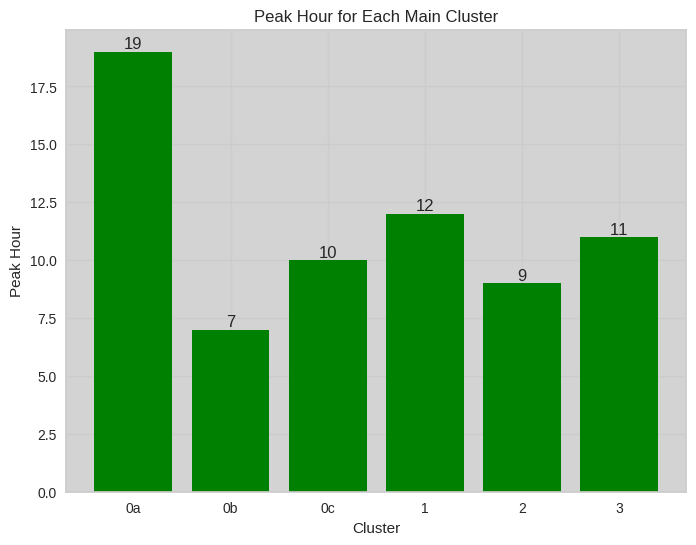

In [44]:
def extract_mode(x):
    mode_value = x.mode().iloc[0] if not x.empty else None
    return mode_value

hourly_peak_mode = clustered_data.groupby(['Cluster'], as_index=False)[['which_hour_peak']].agg(extract_mode)

# Plotting
plt.figure(figsize=(8, 6))
bars = plt.bar(hourly_peak_mode['Cluster'], hourly_peak_mode['which_hour_peak'], color='green')
plt.xlabel('Cluster')
plt.ylabel('Peak Hour')
plt.title('Peak Hour for Each Main Cluster')
plt.xticks(hourly_peak_mode['Cluster'])
plt.gca().set_facecolor('lightgrey')

# Adding bar numbers
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}', ha='center', va='bottom')

plt.show()


**Working hours consumption per building for Each Cluster**

Considered Working Hours: 9 AM to 5 PM

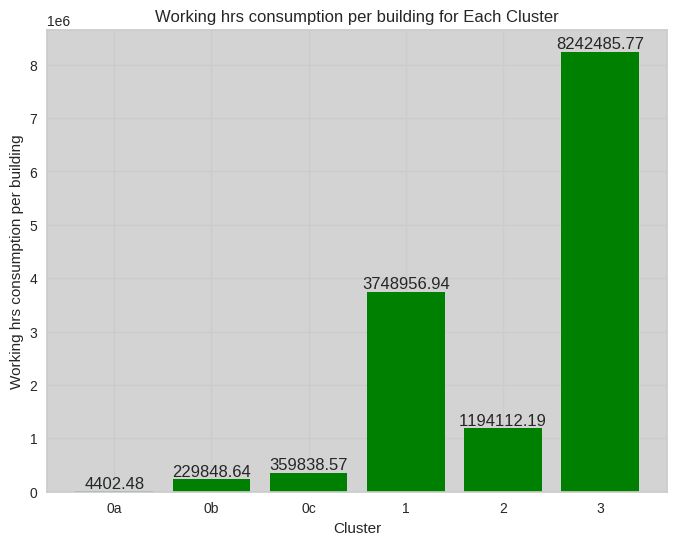

In [45]:
working_hrs_median = clustered_data.groupby(['Cluster'], as_index=False)[['Working_hrs_cons']].median()
working_hrs_median = working_hrs_median.round(2)

# Plotting
plt.figure(figsize=(8, 6))
bars = plt.bar(working_hrs_median['Cluster'], working_hrs_median['Working_hrs_cons'], color='green')
plt.xlabel('Cluster')
plt.ylabel('Working hrs consumption per building')
plt.title('Working hrs consumption per building for Each Cluster')
plt.xticks(working_hrs_median['Cluster'])
plt.gca().set_facecolor('lightgrey')

# Adding bar numbers
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

plt.show()


**Median Time of Day Consumption for Each Clusters**

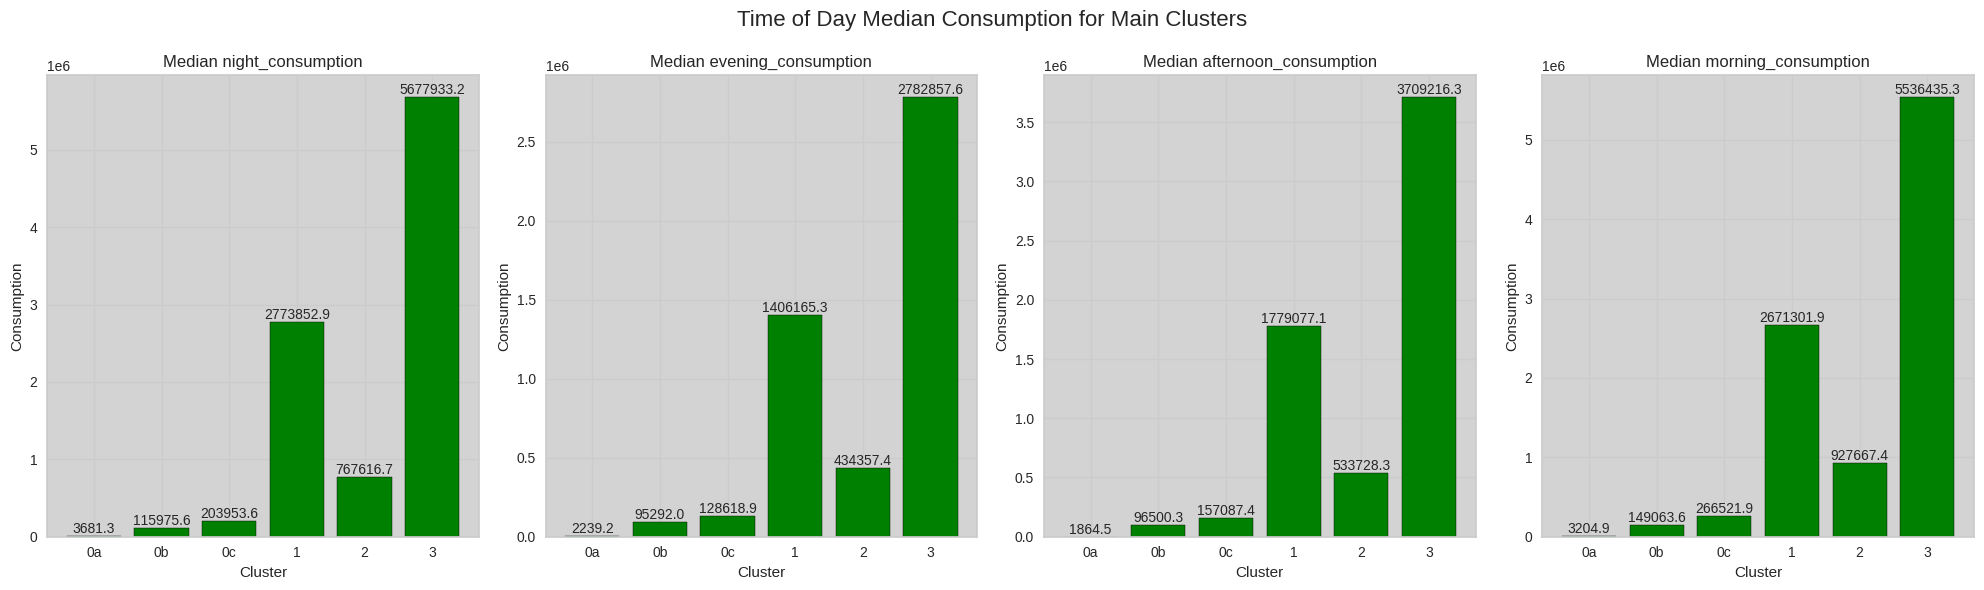

In [46]:
# Function to plot time of day consumption for clusters
def plot_time_of_day_consumption(df, title):
    timeofday_clusters = df.groupby(['Cluster'], as_index=False)[['night_cons', 'evening_cons', 'afternoon_cons', 'morning_cons']].median()

    clusters = list(timeofday_clusters['Cluster'])
    clusters = [str(num) for num in clusters]
    night_cons = timeofday_clusters['night_cons'].values.flatten().round(1)
    evening_cons = timeofday_clusters['evening_cons'].values.flatten().round(1)
    afternoon_cons = timeofday_clusters['afternoon_cons'].values.flatten().round(1)
    morning_cons = timeofday_clusters['morning_cons'].values.flatten().round(1)

    fig, axs = plt.subplots(1, 4, figsize=(20, 6))  # Create a figure with 4 subplots in a row
    for i, values, ax in zip(['night_consumption', 'evening_consumption', 'afternoon_consumption', 'morning_consumption'], [night_cons, evening_cons, afternoon_cons, morning_cons], axs):
        # Plotting the bar chart
        bars = ax.bar(clusters, values, color='green', edgecolor='black')

        # Adding labels and title
        ax.set_xlabel('Cluster')
        ax.set_title(f'Median {i}')
        ax.set_ylabel('Consumption')
        ax.set_facecolor('lightgrey')


        # Adding labels to the bars
        for bar, val in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{val}',
                     ha='center', va='bottom', fontsize=10)

    plt.suptitle(title, fontsize=16)  # Add common title for subplots
    plt.tight_layout()
    plt.show()

# Plotting time of day consumption for main clusters
plot_time_of_day_consumption(clustered_data, 'Time of Day Median Consumption for Main Clusters')


## Below are the features we used to do the profiling. We can also see how  they vary across each cluster.

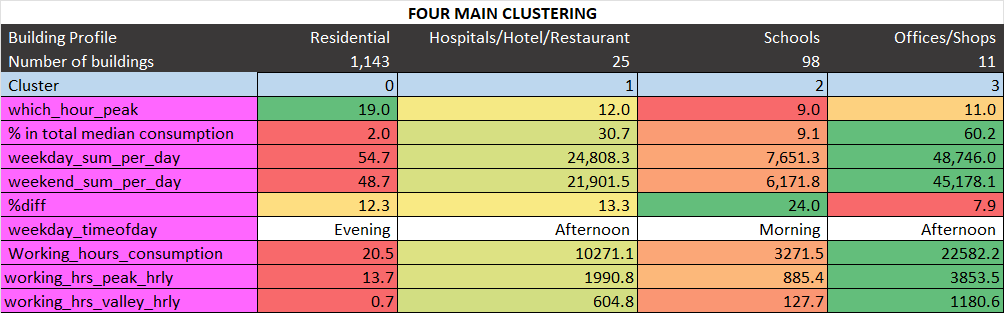

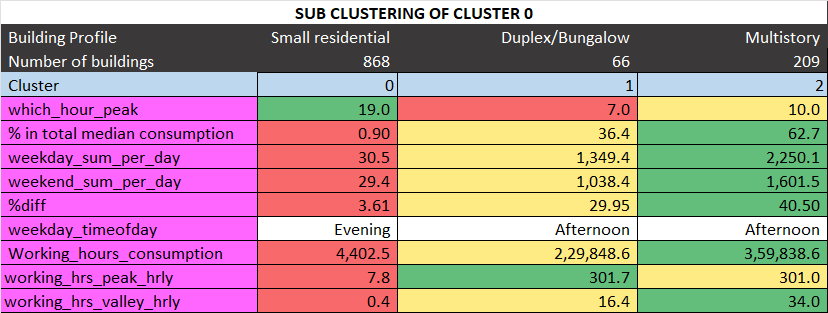

## Cluster Analysis based on Energy Consumption Patterns

### **Main Cluster 0 (Residential):**

#### Sub Cluster 0a: Small Residential Buildings

- **Number of Buildings:** 868
- **Median Total Consumption:** 11,006 units
- **Median Total Weekday Consumption:** 7932 units
- **Median Total Weekend Consumption:** 3091 units
- **Percentage Difference between Per Day Consumption between Weekday and Weekend:** 3.61%
- **Time of Day Peak in Weekdays:** Evening
- **Working Hours Median Consumption:** 4,402 units
- **Hourly Peak during Working Hours:** 7.8 units
- **Hourly Valley during Working Hours:** 0.4 units

**Assumption:**
Number of people residing in Small residential buildings is between 2-4 per house/flat.

**Reasoning:**
- Energy consumption peaks at 7 PM, which is typical for residential buildings as residents return home and increase their usage of electrical appliances.
- Very low percentage of total median consumption, indicating overall lower energy usage, consistent with small residential units.
- Moderate difference between weekday and weekend consumption (3.61%), reflecting less changes in occupancy and behavior.
- Lower consumption during working hours, indicating residents are away during the day.

#### Sub Cluster 0b: Duplex/Bungalow

- **Number of Buildings:** 66
- **Median Total Consumption:** 4,43,872 units
- **Median Total Weekday Consumption:** 3,50,856 units
- **Median Total Weekend Consumption:** 1,09,033 units
- **Percentage Difference between Per Day Consumption between Weekday and Weekend:** 30%
- **Time of Day Peak in Weekdays:** Afternoon
- **Working Hours Median Consumption:** 2,29,848 units
- **Hourly Peak during Working Hours:** 301.7 units
- **Hourly Valley during Working Hours:** 16.4 units

**Assumption:**
Number of people residing in Duplex/Bungalow is between 5-10.

**Reasoning:**
- Time of Day Peak in Weekdays is Afternoon. This could be due to a combination of increased appliance use, and heating/cooling systems running to maintain comfortable indoor temperatures.
- Total median consumption is significantly higher than the 0.90% for small residential buildings but lower than the 62.7% for multistory buildings. This indicates that duplex/bungalow buildings have substantial energy needs, possibly due to their larger size and higher number of appliances/residents compared to small residential buildings.
- Substantial difference between Per Day Consumption between Weekday and Weekend suggests that these buildings have higher energy usage patterns during the weekdays, which could be due to more consistent use of heating/cooling systems, lighting, and appliances when people are at home.
- During working hours, duplex/bungalow buildings consume high amount of energy. This high consumption indicates that these buildings are likely occupied and active during the day, requiring significant energy for daily activities.

#### Sub Cluster 0c: Multistory Buildings

- **Number of Buildings:** 209
- **Peak hour (Maximum for all building):** 10:00 AM
- **Median Total Consumption:** 7,63,821 units
- **Median Total Weekday Consumption:** 5,85,033 units
- **Median Total Weekend Consumption:** 1,68,161 units
- **Percentage Difference between Per Day Consumption between Weekday and Weekend:** 40.5%
- **Time of Day Peak in Weekdays:** Afternoon
- **Working Hours Median Consumption:** 3,59,838 units
- **Hourly Peak during Working Hours:** 301 units
- **Hourly Valley during Working Hours:** 34 units


**Assumption:**
Number of people residing in Multistory buildings is greater than 100.

**Reasoning:**
- Peak consumption at 10 AM, likely due to combined residential morning routines and working professionals doing work from home.
- Highest percentage of total median consumption, typical of larger buildings with higher occupancy or mixed-use.
- Very high energy consumption on weekdays, with substantial weekend usage, characteristic of large multistory buildings.
- Significant difference between weekday and weekend consumption (40.5%), indicating higher weekday activity likely due to mixed-use of buildings. ALso, on weekends residents tend to go on trips.
- Afternoon peak usage, consistent with buildings with mixed usage.


### **Main Cluster 1 (Hotel/Restaurant/Hospital):**
- **Number of Buildings:** 25
- **Peak hour (Maximum for all building):** 12:00 (Afternoon)
- **Median Total Consumption:** 88,80,545.2 units
- **Median Total Weekday Consumption:** 64,50162.0 units
- **Median Total Weekend Consumption:** 22,99660.4 units
- **Percentage Difference between Per Day Consumption between Weekday and Weekend:** 13.3%
- **Time of Day Peak in Weekdays:** Afternoon
- **Working Hours Median Consumption:** 10271.1 units
- **Hourly Peak during Working Hours:** 1990.8 units
- **Hourly Valley during Working Hours:** 604.8 units

**Reasoning:**
- Energy consumption peaks in the afternoon, corresponding to peak activity hours for these establishments.
- There is a moderate difference (13.3%) between weekday and weekend consumption, suggesting relatively consistent energy usage throughout the week, likely due to the continuous operation of these facilities.


### **Main Cluster 2 (Schools):**
- **Number of Buildings:** 98
- **Peak hour (Maximum for all building):** 9:00 (Morning)
- **Median Total Consumption:** 26,29,482.17 units
- **Median Total Weekday Consumption:** 19,89343.4 units
- **Median Total Weekend Consumption:** 6,48040.6 units
- **Percentage Difference between Per Day Consumption between Weekday and Weekend:** 24.0%
- **Time of Day Peak in Weekdays:** Morning
- **Working Hours Median Consumption:** 3271.5 units
- **Hourly Peak during Working Hours:** 885.4 units
- **Hourly Valley during Working Hours:** 127.7 units

**Reasoning:**
- Energy consumption peaks in the morning, likely corresponding to the start of activities in schools.
- There is a significant difference (24.0%) between weekday and weekend consumption, suggesting reduced activity levels during weekends in schools.
- During working hours, the consumption is moderate, with a noticeable hourly peak reflecting the start of activities.

### **Main Cluster 3 (Office, Shops):**
- **Number of Buildings:** 11
- **Peak hour (Maximum for all building):** 11:00 (Afternoon)
- **Median Total Consumption:** 1,74,34,670.91 units
- **Median Total Weekday Consumption:** 1,26,73,967.8 units
- **Median Total Weekend Consumption:** 47,43,700.9 units
- **Percentage Difference between Per Day Consumption between Weekday and Weekend:** 7.9%
- **Time of Day Peak in Weekdays:** Afternoon
- **Working Hours Median Consumption:** 22582.2 units
- **Hourly Peak during Working Hours:** 3853.5 units
- **Hourly Valley during Working Hours:** 1180.6 units

**Reasoning:**
- Energy consumption peaks in the afternoon, corresponding to peak business hours for offices and shops.
- During working hours, the consumption is substantial, with significant hourly peaks reflecting peak business activities.
- There is a small difference (7.9%) between weekday and weekend consumption, suggesting relatively consistent energy usage throughout the week, likely due to continuous operation.



# Demand-Response Program

## Why do we need Demand-Response Programs:

**1. Grid Stability and Reliability**

- Peak Load Management: Energy demand varies throughout the day, often peaking during certain hours (e.g., late afternoon and early evening). Demand response programs help shift or reduce this peak load, preventing overloading of the grid.

- Preventing Blackouts: By reducing the demand during peak times or emergencies, these programs help prevent blackouts and brownouts, ensuring a continuous supply of electricity.

**2. Economic Efficiency**

- Cost Savings: Reducing peak demand can lower the need for expensive and inefficient peaking power plants that are only used during high demand. This leads to overall cost savings for utilities and consumers.

- Incentives for Consumers: Consumers participating in demand response programs can receive financial incentives for reducing their electricity usage during peak times, leading to lower energy bills.

**3. Environmental Benefits**

- Reducing Emissions: By lowering the reliance on peaking power plants, which are often fossil fuel-based and less efficient, demand response programs can reduce greenhouse gas emissions and other pollutants.

- Integration of Renewable Energy: Demand response can help balance the intermittent nature of renewable energy sources like wind and solar. By adjusting demand to align with periods of high renewable generation, the grid can utilize more clean energy.


**4. Consumer Empowerment**

- Increased Awareness: Demand response programs often involve smart meters and other technologies that give consumers more information about their energy use, helping them make more informed decisions.

- Active Participation: These programs encourage consumers to play an active role in energy management, promoting energy conservation and efficiency.

**5. Regulatory and Policy Support**

- Meeting Regulatory Requirements: Many regions have regulatory mandates for utilities to implement demand response programs as part of broader energy efficiency and renewable energy policies.

- Policy Alignment: Demand response aligns with policy goals aimed at reducing energy consumption, managing peak demand, and transitioning to a cleaner energy system.

## Factors Affecting DR Programs

### 1. Response Time
The speed at which participants can adjust their energy usage in response to a DR signal.

### 2. Flexibility
The ability of participants to adjust their energy usage without significantly impacting their operations or comfort.

### 3. Financial Incentives
Monetary rewards or cost savings offered to participants for adjusting their energy usage.

### 4. Load Profile
The pattern of energy consumption over time for a customer or group of customers.

### 5. Price Structure (Fixed vs. Market-Based)
The type of pricing mechanism used in the DR program. Example - Fixed Price Programs or Market-Based Programs.

### 6. Control
Who would have control in adjusting energy consumptions at peak lor valley times, utility or participants.


## DR Program for each profile

### Small Residential (Cluster 0):
- **Time-of-Day Tariff (TOD):** ToD tariffs involve different electricity pricing based on the time of day. Typically, electricity is cheaper during off-peak hours (late night and early morning) and more expensive during peak hours (late afternoon and evening). Residents could be notified on the same day of the potential peaks so that they could plan accordingly.

 Recommendation: Residents can shift their energy-intensive activities (like laundry, dishwashing, vacuuming or ironing) to off-peak times to save on costs. Using smart thermostats to automatically adjust temperature settings based on the ToD pricing schedule.
- **Direct Load Control:** Utilities can remotely control certain appliances or systems in small residential buildings during times of peak demand, such as temporarily adjusting thermostat settings or cycling off non-essential equipment, to reduce overall energy consumption.
DLC programs require minimal action from residents once they are enrolled. Participants receive financial benefits such as bill credits or reduced rates in exchange for allowing the utility to control certain appliances.
Example: Air conditioners are cycled off for short periods during high demand times.

- **Behavioral Demand Response:** In this programs, customers are encouraged to voluntarily reduce their energy use during peak periods through notifications and incentives. Residents who will enroll in this program, will receive alerts (via text, email, or app notifications) about upcoming peak periods and are encouraged to reduce consumption, often with the promise of lower bills or rebates if they participate.

### Multistory Buildings (Cluster 0):
- **Automated Demand Response (ADR):** ADR involves the use of automated systems to manage and reduce electricity consumption during peak demand periods or in response to price signals. This typically involves advanced building management systems (BMS) and smart devices that can respond automatically to DR events without manual intervention.
ADR can be scaled across multiple floors, providing comprehensive energy management. The BMS selectively reduces HVAC usage in less critical areas such as lobbies, hallways, and conference rooms while maintaining comfort in occupied spaces. Automated notifications remind residents to turn off non-essential devices before leaving their houses.
- **Direct Load Control:** DLC programs allow utilities to remotely control specific high-energy-consuming systems and appliances during peak demand periods.  
The utility can remotely adjust HVAC settings during peak demand periods. For example, they may cycle the HVAC system off for short intervals (e.g., 15-30 minutes every hour) during a peak demand event. Water heaters are pre-heated during off-peak hours to ensure sufficient hot water supply during controlled periods.

### Duplex/Bungalow (Cluster 0):
- **Automated Demand Response (ADR):** Bungalows and duplexes typically exhibit predictable energy usage patterns, especially with a peak in the afternoon. This predictability makes it easier to automate responses to demand signals.

 Recommendation - The ADR system automatically dims non-essential lighting in common areas and exterior lighting during peak periods. Non-essential appliances (e.g., dishwashers, washing machines) are scheduled to operate during off-peak hours. During peak hours (e.g., 2 PM to 5 PM), the ADR system slightly increases the thermostat setpoint by 2-3 degrees to reduce the load on air conditioning systems without significantly impacting comfort.

- **Direct Load Control:** Utilities can implement direct load control measures in these houses to reduce energy usage during peak demand periods, helping to alleviate strain on the grid and avoid potential blackouts. Residents benefit from lower energy costs due to reduced peak demand charges and financial incentives provided by the utility.




### Hotel/Restaurant/Hospital (Cluster 1):
Since hotels, restaurant and hospital has more or less constant energy consumption throughout the day and continuous supply is also important, they need a demand response program that is flexible in consumption pattern and not in the control of utilities. Also, they can't make promises beforehand about their predictive consumption.

- **Energy Storage Systems (ESS):** Energy Storage Systems (ESS) play a crucial role in enabling institutions like hospitals to actively engage in demand response. By discharging stored electricity during critical events or peak hours, hospitals can significantly reduce their demand from the grid. A noteworthy example is a California hospital which installed a 1.5 megawatt (MW) battery system that can provide up to 10% of its peak load and participate in the state's demand response program, saving an estimated $800,000 per year.

- **Demand Bidding:** In a demand bidding program, participants specify the amount of electricity they are willing to reduce at certain price points, and grid operators or utilities select the bids to balance supply and demand. Also, there is no penalties for not meeting the promise. Even, they may receive incentives such as priority access to electricity or preferred service levels based on their bids. The focus is on meeting consumer demand efficiently and at competitive prices. In demand bidding, consumers actively participate in determining the price and quantity of electricity or services they require. They may adjust their bids based on their immediate needs, preferences, or budget constraints.

  For hotels, restaurants, or hospitals, this approach helps in reducing energy consumption by allowing them to participate in demand response programs as they will not be penalize for not keeping thier promise. But they will recieve some incentives as benefits.

  Recommendation: The building management system (BMS) is equipped with automated controls to adjust power usage based on real-time grid frequency needs. The BMS can temporarily adjust HVAC settings to reduce load without affecting guest/patients comfort significantly. Automated lighting controls can dim or turn off non-essential lighting during DR events to reduce load.  can shifts its food preparation for non-peak hours, using pre-cooked or ready-to-serve options during peak hours to reduce kitchen appliance usage.


### Schools (Cluster 2):
 Schools and warehouse usually have morning and afternoon consumption. They need continuous consumption at that time but can promise a particular energy consumption as school staff and students could be encouraged to limit the electricity usage.


- **Interruptible Load Programs** - Interruptible Load Programs (ILP) are demand response initiatives where participants agree to reduce or shut down certain non-essential loads upon request by the utility or grid operator, usually during times of peak demand or grid stress. In return, participants receive financial incentives such as reduced electricity rates or direct payments. Non-compliance during designated events can result in penalties. Notification is usually on the day of request or peak day.

  School operational hours are consistent, making it easier to plan and implement load reduction strategies. The utility could notify the school 6 hours in advance of a predicted peak demand period could be from 2 PM to 4 PM. Schools could maximize natural lighting and turn off or dim artificial lighting where possible, especially in corridors, gymnasiums, and other large spaces.

- **Capacity Bidding:** The primary objective of capacity bidding is to secure additional capacity or flexibility to the grid during times of high demand or system constraints. Participants commit to reducing their electricity usage in advance, typically in exchange for financial incentives, to provide this capacity when needed. Notification is usually a day ahead of peak event.

  For schools, participanting in capacity bidding programs receive incentives, such as payments or credits, for committing to reduce their electricity usage during specified periods in the future. The incentives compensate them for the flexibility they provide to the grid.

Schools could use both DR programs simultaneously as ILP is usually used in emergency situations while capacity bidding could be used with proper planning, thereby helping grids in both kind of situations.


### Offices/Shops (Cluster 3):
Office and shops contributes highest in overall total consumption. Also thier consumption can be highest in afternoon or evening. Thier most of the consumption goes to lightings, temperature control, ICT etc. They have some level of flexibility in controlling thier consumpition by switching off lights when not in use, using 5 star ACs etc.

- **Real-Time Pricing (RTP):** RTP is a demand response program where electricity prices fluctuate on an hourly or sub-hourly basis, reflecting real-time changes in wholesale electricity market prices. Participants are incentivized to adjust their electricity usage in response to these price signals. By reducing consumption during high-price periods and shifting usage to lower-price times, large offices can achieve significant cost savings.

 Recommendation: Adjusting thermostat setpoints slightly higher in summer or lower in winter during high-price periods (e.g., raise the temperature by 2-3 degrees). Delay or advance energy-intensive activities, such as data center cooling, to align with lower-priced hours. Offices can install motion sensors and programmable lighting controls to ensure lights are off when areas are unoccupied. Utilize natural light during daytime hours to minimize the use of artificial lighting. Use energy-efficient office equipment and enable power-saving modes to reduce consumption during peak hours.

- **Critical Time pricing:** CPP involves significantly higher electricity prices during critical peak periods, typically a few hours per day when the electricity grid is under stress. These periods are announced by the utility in advance, often the day before, based on forecasted high demand or system constraints.
Offices can reduce their energy consumption or shift it to off-peak hours during CPP events, resulting in cost savings on electricity bills. Benefit is that they can have discount on all part and on-peak usage on all other days of the year/season as CCT pricing is communicated to them one day before.


- **Demand Bidding DR:** Large office buildings can effectively participate in demand bidding programs by leveraging their significant energy loads. Offices can create a detailed demand response action plan outlining specific steps to reduce load during demand response events. This plan should include which systems to shut down or reduce, and the procedures for doing so. They can also invest in building automation systems that can quickly and efficiently reduce loads in response to a demand response signal. When a bid is accepted, implement the pre-planned load reduction measures promptly. This could involve adjusting thermostats, dimming or turning off lights, powering down non-essential equipment, and managing elevator usage.

 For maximum benefits, they should develop a bidding strategy based on the cost of load reduction and the operational impact. Consider factors such as the minimum acceptable price for load reduction and the maximum load that can be reduced.


These demand response programs are suitable for each cluster based on their energy consumption patterns and building characteristics. They offer opportunities for reducing energy usage during peak periods, contributing to grid stability, and earning financial incentives or benefits in return.

# Conclusion

In this unsupervised clustering challenge, we began by extracting approximately 190 features from a variety of sources, including U.S. holidays, seasons, time series, and percentiles, for a total of 1,277 buildings. Using a subset of these features, which best explained the distribution of data, we applied K-means clustering and identified four optimal clusters.

Due to the high volume of buildings in Cluster 0, we conducted further analysis and determined that it likely contained different kind of residential buildings. To refine our understanding, we performed additional clustering on Cluster 0, resulting in three distinct sub-clusters. Ultimately, our comprehensive profiling yielded six distinct clusters: small residential, multistory buildings, bungalow/duplex, large offices/shops, schools, and hospitals/restaurants/hotels.

Based on this detailed profiling, we recommended specific demand response (DR) programs for each cluster, along with tailored energy reduction methods. This approach ensures that each building type can effectively participate in DR programs, optimizing energy usage and contributing to overall grid stability.